# A - Préparation de l'environnement

### Importation des packages

In [8]:
library(corrplot)
library(ggplot2)
library(lattice)
library(rpart)
library(partykit)
library(randomForest)
library(ROCR)
library(caret)
library(missForest)
library(reshape2)
library(FactoMineR)
library(factoextra)
#library(rgl)
library(plotly)
library(dplyr)
library(gridExtra)
library(bestglm)
library(MASS)
library(VGAM)
library(e1071)
library(glmnet)
library(broom)
library(gbm)
library(bestglm)

Warning message:
“package ‘gbm’ was built under R version 3.6.2”
Loaded gbm 2.1.8



### Importation des données <br>


http://archive.ics.uci.edu/ml/datasets/Energy+efficiency

In [9]:
data.complet <- read.csv('DataEnergy.csv')
x <- data.complet
head(x)

Relative.compactness Surface.area Wall.area Roof.area Overall.height
1 0.9829276            530.4900     306.4846  112.0027  7             
2 0.9835473            519.8724     299.7763  110.0480  7             
3 0.9794535            516.1912     303.3744  106.4084  7             
4 0.9777325            518.9241     292.8122  113.0559  7             
5 0.9030294            552.9689     316.2361  118.3664  7             
6 0.8909102            558.6037     314.9162  121.8437  7             
  orientation Glazing.area  Glazing.area.distr Energy   Energy.efficiency
1 North        1.609490e-02 0                  34.26394 B                
2 East        -9.386813e-03 0                  34.58975 B                
3 South       -6.974937e-04 0                  38.77805 C                
4 West         9.554434e-06 0                  37.94781 C                
5 North       -6.592326e-03 0                  47.67586 D                
6 East        -1.612145e-02 0                  41.90847 C

## **Résumé des variables :**

* **Relative compactness** : Compacité relative (propriété liée à la forme du batiment et sa surface)
* **Surface area** : Superficie totale du batiment
* **Wall area** : Surface des murs
* **Roof area** : Surface du toit
* **Overal height** : Hauteur du batiment (Qualitative ordonnée: 3,5m et 7m)
* **Orientation** : Orientation du batiment (North, East, South, West)
* **Glazing area** : Surface totale des vitrages du batiment 
* **Glazing area distr** : Orientation des vitrages du batiment (55% East, 55% South, etc)
* **Energy** : quantifie les performances énergétique du batiment 
* **Energy efficiency** : Lettre de classification des performances énergétique du batiment

<br>

### Transformation des variables

In [10]:
str(x)

'data.frame':	768 obs. of  10 variables:
 $ Relative.compactness: num  0.983 0.984 0.979 0.978 0.903 ...
 $ Surface.area        : num  530 520 516 519 553 ...
 $ Wall.area           : num  306 300 303 293 316 ...
 $ Roof.area           : num  112 110 106 113 118 ...
 $ Overall.height      : num  7 7 7 7 7 7 7 7 7 7 ...
 $ orientation         : Factor w/ 4 levels "East","North",..: 2 1 3 4 2 1 3 4 2 1 ...
 $ Glazing.area        : num  1.61e-02 -9.39e-03 -6.97e-04 9.55e-06 -6.59e-03 ...
 $ Glazing.area.distr  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Energy              : num  34.3 34.6 38.8 37.9 47.7 ...
 $ Energy.efficiency   : Factor w/ 7 levels "A","B","C","D",..: 2 2 3 3 4 3 3 3 4 4 ...


In [11]:
x$Glazing.area.distr <- as.factor(x$Glazing.area.distr)
levels(x$Glazing.area.distr) <- c("Uniform", "55% North", "55% East", 
                                  "55% South", "55% West", "No glazing")


x$Energy.efficiency <- factor(x$Energy.efficiency, ordered=TRUE)


#options(repr.plot.width = 8, repr.plot.height = 3) 
#histogram(x$Glazing.area.distr, main ="Repartition selon les Glazing Area", xlab="Glazing Area")
#x$Energy[x$Load<=30] = 'A'
#x$Energy[x$Load>30 & x$Load<=35] = 'B'
#x$Energy[x$Load>35 & x$Load<=45] = 'C'
#x$Energy[x$Load>45 & x$Load<=55] = 'D'
#x$Energy[x$Load>55 & x$Load<=65] = 'E'
#x$Energy[x$Load>65 & x$Load<=75] = 'F'
#x$Energy[x$Load>75] = 'G'

In [12]:
summary(x)

 Relative.compactness  Surface.area     Wall.area       Roof.area    
 Min.   :0.6125       Min.   :501.4   Min.   :234.3   Min.   :105.3  
 1st Qu.:0.6779       1st Qu.:598.7   1st Qu.:291.8   1st Qu.:137.4  
 Median :0.7517       Median :673.1   Median :315.8   Median :183.3  
 Mean   :0.7645       Mean   :671.3   Mean   :318.3   Mean   :176.5  
 3rd Qu.:0.8350       3rd Qu.:744.6   3rd Qu.:343.0   3rd Qu.:220.5  
 Max.   :0.9912       Max.   :826.0   Max.   :425.8   Max.   :225.8  
                                                                     
 Overall.height orientation  Glazing.area       Glazing.area.distr
 Min.   :3.50   East :192   Min.   :-0.02401   Uniform   : 48     
 1st Qu.:3.50   North:192   1st Qu.: 0.10306   55% North :144     
 Median :5.25   South:192   Median : 0.24752   55% East  :144     
 Mean   :5.25   West :192   Mean   : 0.23435   55% South :144     
 3rd Qu.:7.00               3rd Qu.: 0.39119   55% West  :144     
 Max.   :7.00               Max.   : 0

#### Commentaires : 

On remarque des valeurs négatives pour la variable Glazing Area, qui représente pourtant la surface totale des vitrages. En fait, ces valeurs négatives sont dues à un bruit ajouté. 
Regardons comment sont réparties ces valeurs négatives afin de leur appliquer une correction.

In [13]:
summary(x[which(x$Glazing.area<0),]$Glazing.area.distr)

Uniform  55% North   55% East  55% South   55% West No glazing 
        24          0          0          0          0          0

#### Commentaires : 

D'après le resultat ci-dessus, toutes les valeurs de Glazing.area inférieures à 0 n'appartiennent pas à la catégorie No glazing. On ne peut donc pas forcer leur valeur à 0. 

Ainsi, on va utiliser un algorithme de MissForest dans le but de se rapprocher au plus près de la valeure d'origine qui doit être supérieure à 0.

In [14]:
options(repr.plot.width = 6, repr.plot.height = 5) 

## ATTENTION RUN UNE FOIS SEULEMENT 
xcop <- x
xcop$Glazing.area[xcop$Glazing.area<0] <- NA
cat(sum(is.na(xcop$Glazing.area))/length(xcop$Glazing.area)*100, 
    "% données manquantes dans la variable Glazing area \n\n")
Xna <- missForest(xcop)

3.125 % données manquantes dans la variable Glazing area 

  missForest iteration 1 in progress...done!
  missForest iteration 2 in progress...done!
  missForest iteration 3 in progress...done!


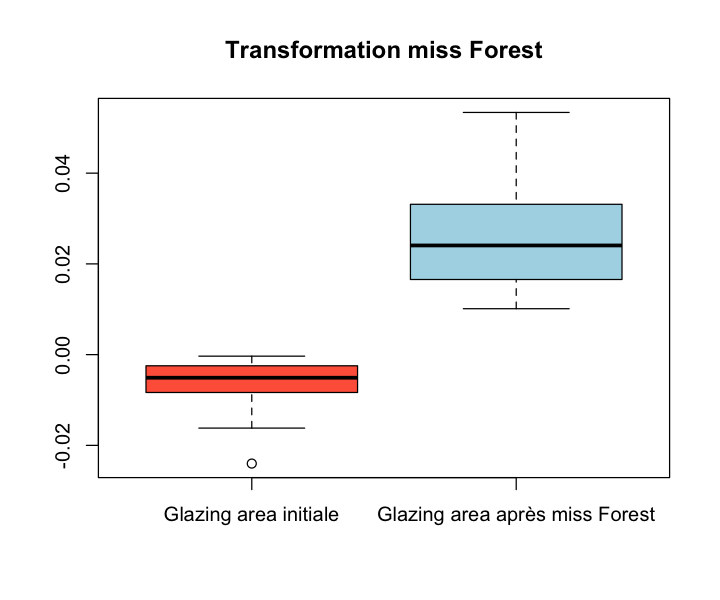

In [15]:
a <- which(is.na(xcop$Glazing.area))
boxplot(x$Glazing.area[a], Xna$ximp$Glazing.area[a], 
        main = "Transformation miss Forest", col=c('tomato1','lightblue'), 
        names=c('Glazing area initiale', 'Glazing area après miss Forest')) 
x<- Xna$ximp

#### Commentaires : 

Les valeurs initialement inférieures à 0 ont bien été réajustées par des valeurs supérieures à 0. Dans la suite de notre analyse, nous prendrons en considération uniquement ces nouvelles valeurs qui semblent plus cohérentes avec les valeurs attendues de la variable Gazing Area.

<br>

# B - Analyse des données

## 1) Statistiques descriptives univariées

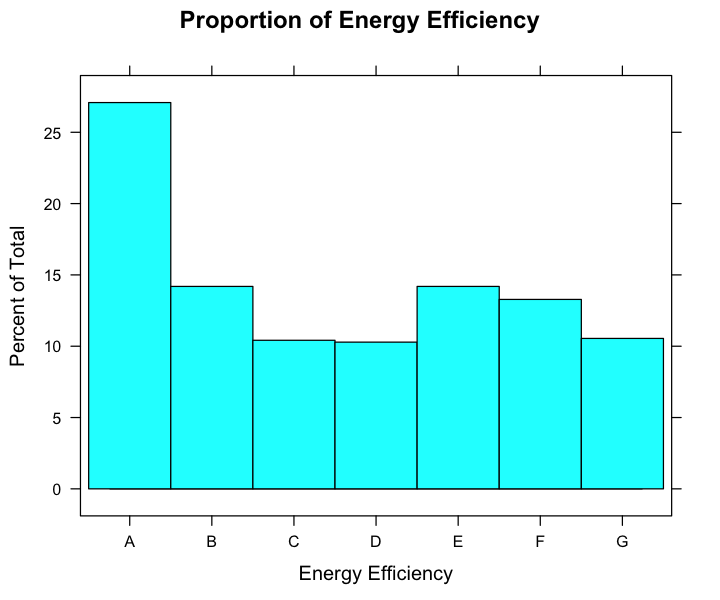

In [16]:
histogram(x$Energy.efficiency, freq=FALSE, xlab="Energy Efficiency", 
          main="Proportion of Energy Efficiency")

#### Commentaires :

La répartition des données par classe énergie est plutot uniforme. On observe cependant  que la classe A qui est majoritaire dans ce jeu de données.

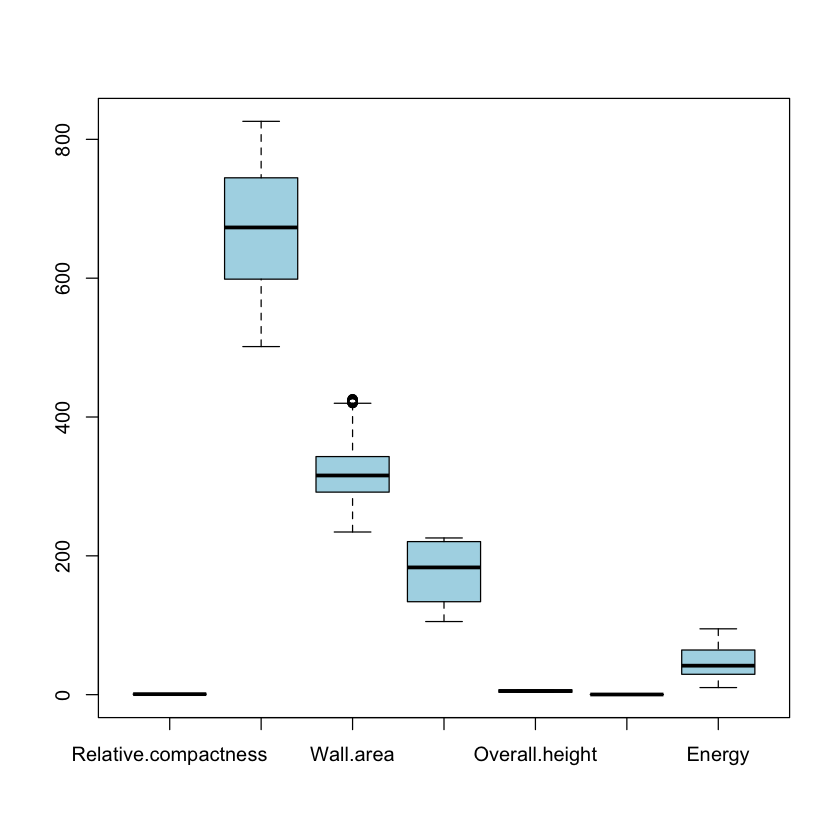

In [17]:
options(repr.plot.width = 7, repr.plot.height = 7) 
boxplot(x[,-c(6,8,10,11)], col='lightblue') #Add legend Add inclinaison
#Pas dans le même ordre de grandeur -> norm = True pendant ACP

#### Commentaires :

Les variables ne sont pas toutes de même ordre de grandeur mais les distributions semblent homogènes. Etant donné les ordres de grandeurs bien différents, une attention particulière sera accordée lors de la réalisation de l'ACP.

Il faut maintenant étudier plus précisemment la répartition des variables mal représentées sur le graphique.

DEMANDER AU PROF

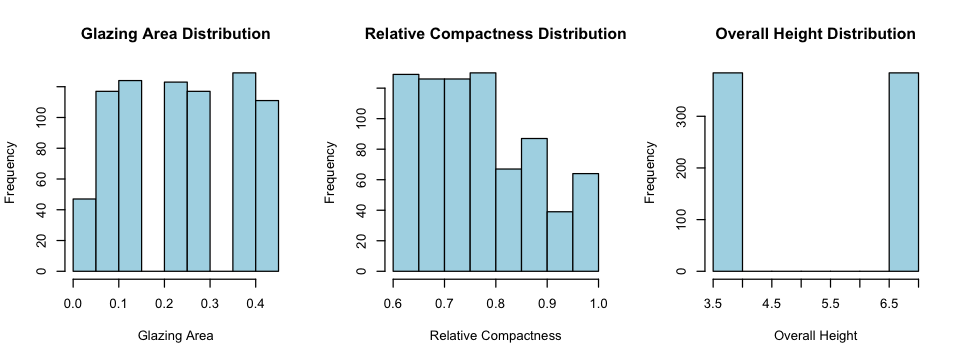

In [18]:
par(mfrow=c(1,3))
options(repr.plot.width = 8, repr.plot.height = 3) 

hist(x$Glazing.area, xlab='Glazing Area', main='Glazing Area Distribution',col='lightblue')
hist(x$Relative.compactness,,xlab= 'Relative Compactness' ,main = 'Relative Compactness Distribution',col='lightblue')
hist(x$Overall.height, xlab ='Overall Height',  main = 'Overall Height Distribution',col='lightblue')

#### Commentaires :

Au premier abord, il n'y a pas de transformation de variables nécessaires car les distributions sont "symétriques".

CF PROF

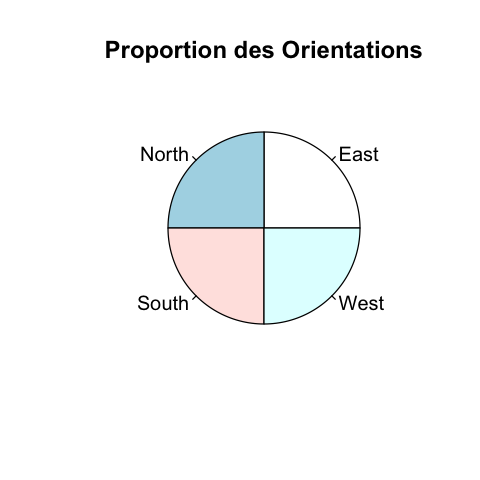

In [19]:
options(repr.plot.width = 4, repr.plot.height = 4) 
pie(table(x$orientation), main = "Proportion des Orientations")

#### Commentaires : 

La répartition des orientations des bâtiments est uniforme pour le jeu de données.

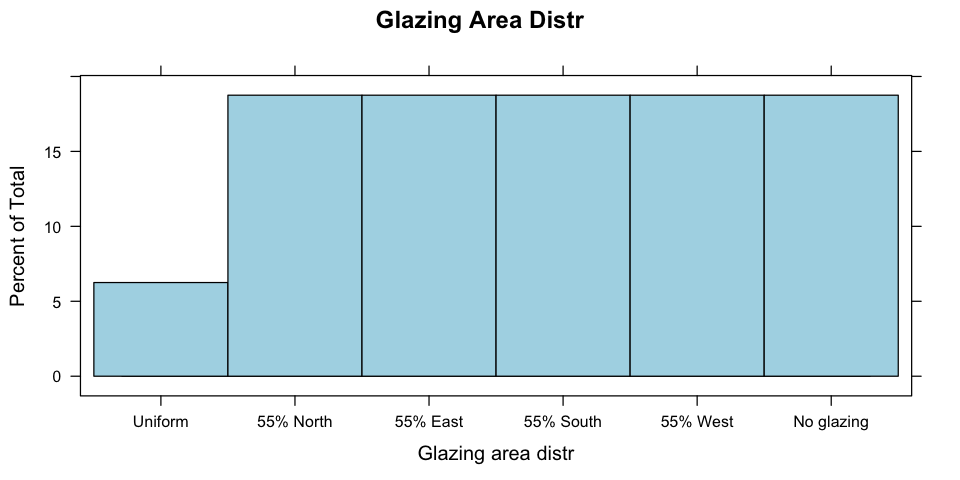

In [20]:
options(repr.plot.width = 8, repr.plot.height = 4) 
histogram(x$Glazing.area.distr,xlab= 'Glazing area distr' ,main = 'Glazing Area Distr',col='lightblue')

#### Commentaires : 

La répartition des orientations des vitrages est équitable entre les différentes classes (55% Nord, 55% Est, 55% Sud, 55% Ouest et sans vitrage). Cependant, l'orientation des vitrages de type "uniform" est minoritaire.

<br>

## 2) Statistiques descriptives multivariées

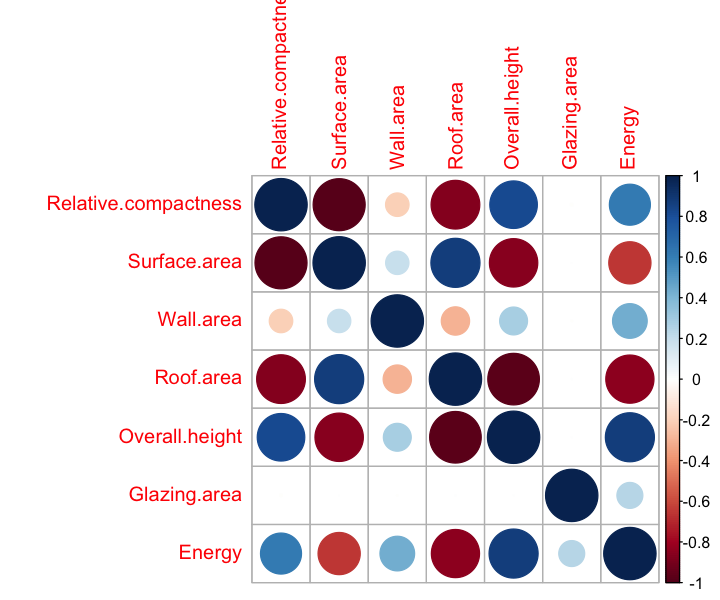

In [21]:
options(repr.plot.width = 6, repr.plot.height = 5) 
M <- cor(x[,-c(6,8,10,11)])
corrplot(M)

**Commentaire :**

Les variables sont globalement très corrélées entre elles. 

   * **Relative compactness** est très fortement correlé négativement avec Surface area (-0.98) et Roof Area (-0.87). Relative compactness est également correlé positivement avec Overall.height. Il doit exister un lien numérique entre ces variables que nous étudierons par la suite.

   * **Overall.height** est très corrélé avec Energy 
    
Il est difficile de tirer des conclusions avec le graphique des corrélations. Regardons la matrice de scatterplots.

*(%A confirmer Une hypothèse serait que les batiments ont la même forme, ainsi seule la surface influe sur cette propriété.*

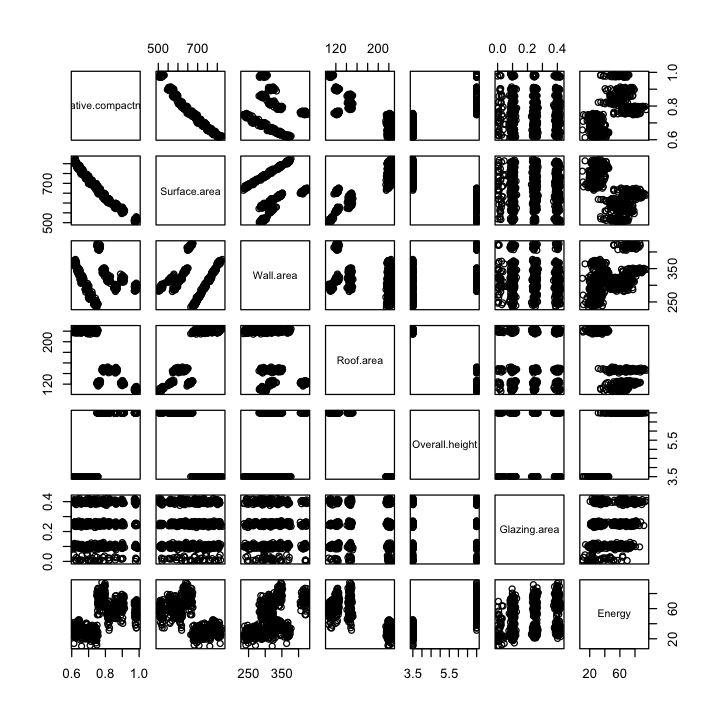

In [22]:
options(repr.plot.width = 6, repr.plot.height = 6)
pairs(x[,-c(6,8,10,11)])

On remarque une relation linéaire entre Relative.compactness et Surface.area

On voit que Glazing.area, qui est une variable quantitative, est finalement répartie selon 4 intervalles.

In [23]:
fig <- plot_ly(x, x = ~Roof.area, y = ~Wall.area, z = ~Surface.area, color = ~Energy.efficiency)
fig <- fig %>% add_markers()
fig <- fig %>% layout(scene = list(xaxis = list(title = 'Roof Area'),
                     yaxis = list(title = 'Wall Area'),
                     zaxis = list(title = 'Surface Area')))

fig

Warning message:
“`arrange_()` is deprecated as of dplyr 0.7.0.
Please use `arrange()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


HTML widgets cannot be represented in plain text (need html)

In [24]:
## On vérifie la relation Surface.area = Wall.area + 2*Roof.area
a=x$Surface.area-(x$Wall.area+2*x$Roof.area)
cat("Nombre de valeurs pour lesquelles la relation 'Surface.area = Wall.area + 2*Roof.area' n'est pas vérifié : ", length(which(round(a,3)!=0)))

Nombre de valeurs pour lesquelles la relation 'Surface.area = Wall.area + 2*Roof.area' n'est pas vérifié :  0

La surface est calculée en sommant la surface des murs et en ajoutant deux fois la surface du toit.

La relation étant vérifiée pour tous les points de notre jeu de donnée, nous allons pouvoir supprimer une ou plusieurs variables étant donné que les informations sont redondantes.

Pour continuer l'analyse, on va donc supprimer la surface totale qui regroupe deux informations importantes.
On voit en effet sur le plot suivant que ce sont la surface de mur et la surface de toit qui contiennent des informations.

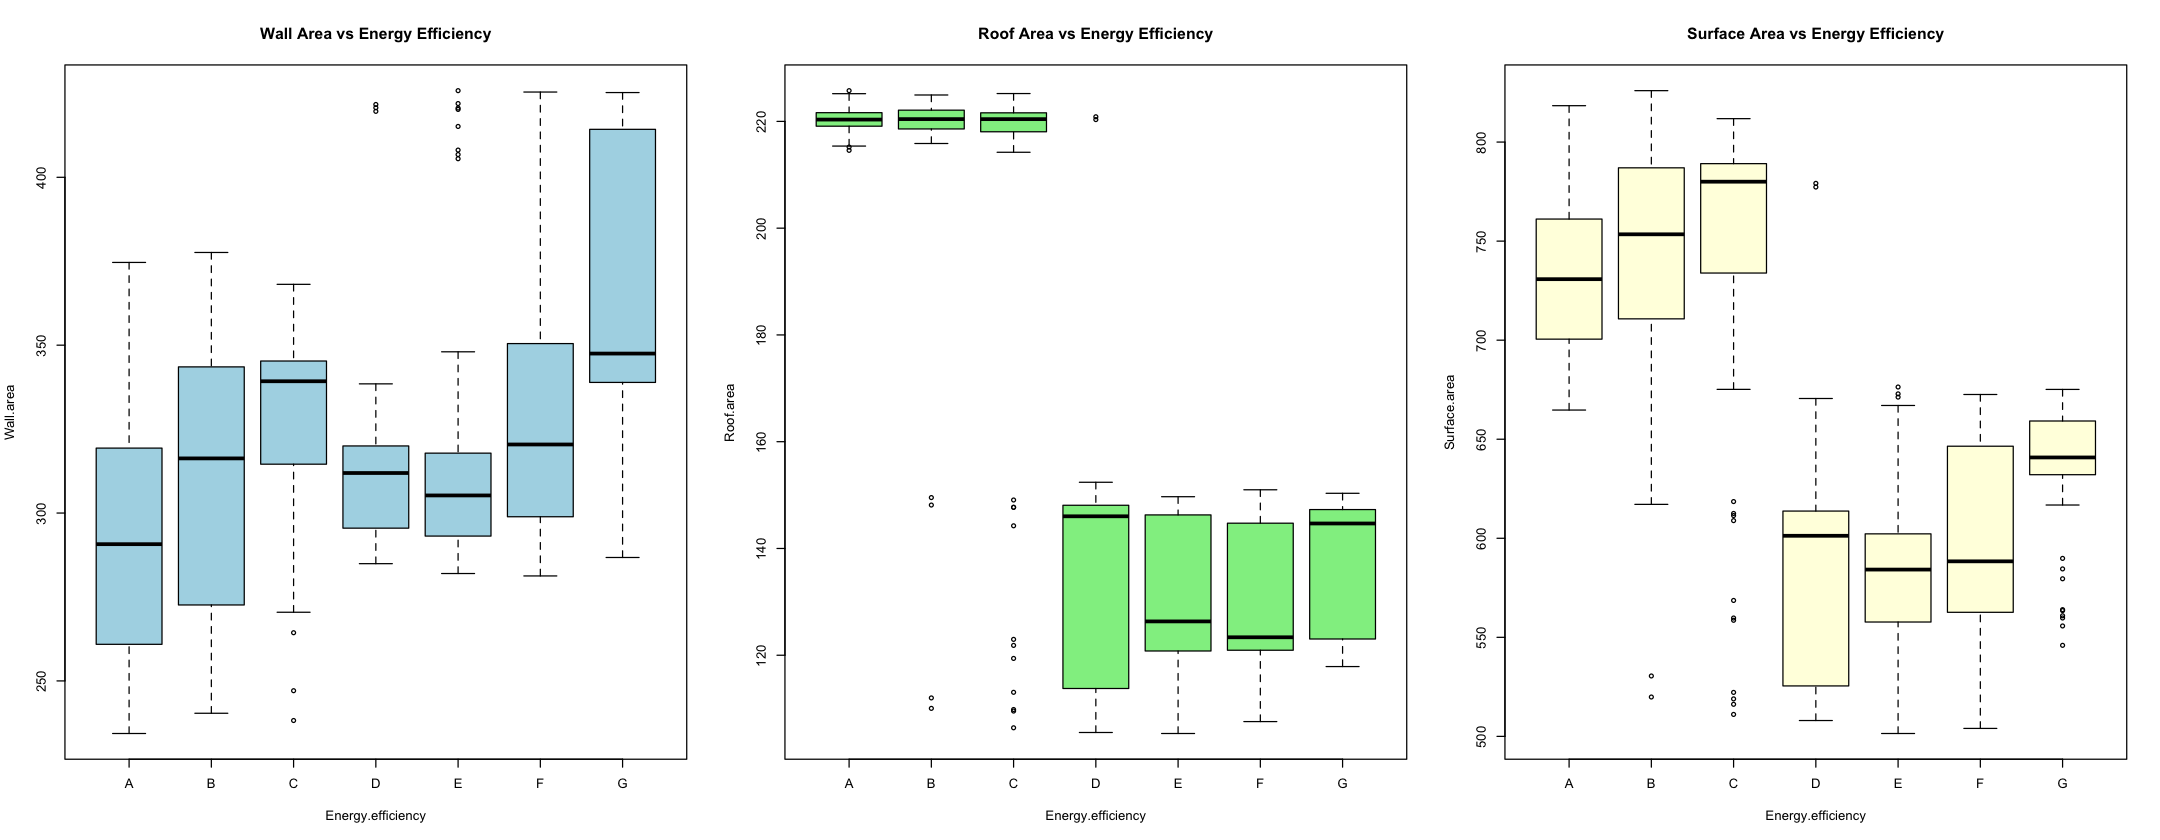

In [25]:
#En cours d'esai sera modifié prochaine séance
options(repr.plot.width = 18, repr.plot.height = 7) 

par(mfrow=c(1,3))
boxplot(Wall.area ~Energy.efficiency, data=x, col='lightblue', main="Wall Area vs Energy Efficiency")
boxplot(Roof.area ~Energy.efficiency, data=x, col='lightgreen', main="Roof Area vs Energy Efficiency")
boxplot(Surface.area ~Energy.efficiency, data=x, col='lightyellow', main="Surface Area vs Energy Efficiency")


On remarque sur ces graphiques que les classes A, B et C ont une surface de toît élevée. De la même façon, ces classes ont une surface totale élevée.

La tendance est inversée pour les classes D, E, F et G.

**On retire donc la variable Surface Area.**

In [26]:
head(x)

Relative.compactness Surface.area Wall.area Roof.area Overall.height
1 0.9829276            530.4900     306.4846  112.0027  7             
2 0.9835473            519.8724     299.7763  110.0480  7             
3 0.9794535            516.1912     303.3744  106.4084  7             
4 0.9777325            518.9241     292.8122  113.0559  7             
5 0.9030294            552.9689     316.2361  118.3664  7             
6 0.8909102            558.6037     314.9162  121.8437  7             
  orientation Glazing.area Glazing.area.distr Energy   Energy.efficiency
1 North       1.609490e-02 Uniform            34.26394 B                
2 East        1.451379e-02 Uniform            34.58975 B                
3 South       2.247933e-02 Uniform            38.77805 C                
4 West        9.554434e-06 Uniform            37.94781 C                
5 North       2.066201e-02 Uniform            47.67586 D                
6 East        1.574394e-02 Uniform            41.90847 C

In [27]:
x <- dplyr::select(x,-Surface.area)
head(x)

Relative.compactness Wall.area Roof.area Overall.height orientation
1 0.9829276            306.4846  112.0027  7              North      
2 0.9835473            299.7763  110.0480  7              East       
3 0.9794535            303.3744  106.4084  7              South      
4 0.9777325            292.8122  113.0559  7              West       
5 0.9030294            316.2361  118.3664  7              North      
6 0.8909102            314.9162  121.8437  7              East       
  Glazing.area Glazing.area.distr Energy   Energy.efficiency
1 1.609490e-02 Uniform            34.26394 B                
2 1.451379e-02 Uniform            34.58975 B                
3 2.247933e-02 Uniform            38.77805 C                
4 9.554434e-06 Uniform            37.94781 C                
5 2.066201e-02 Uniform            47.67586 D                
6 1.574394e-02 Uniform            41.90847 C

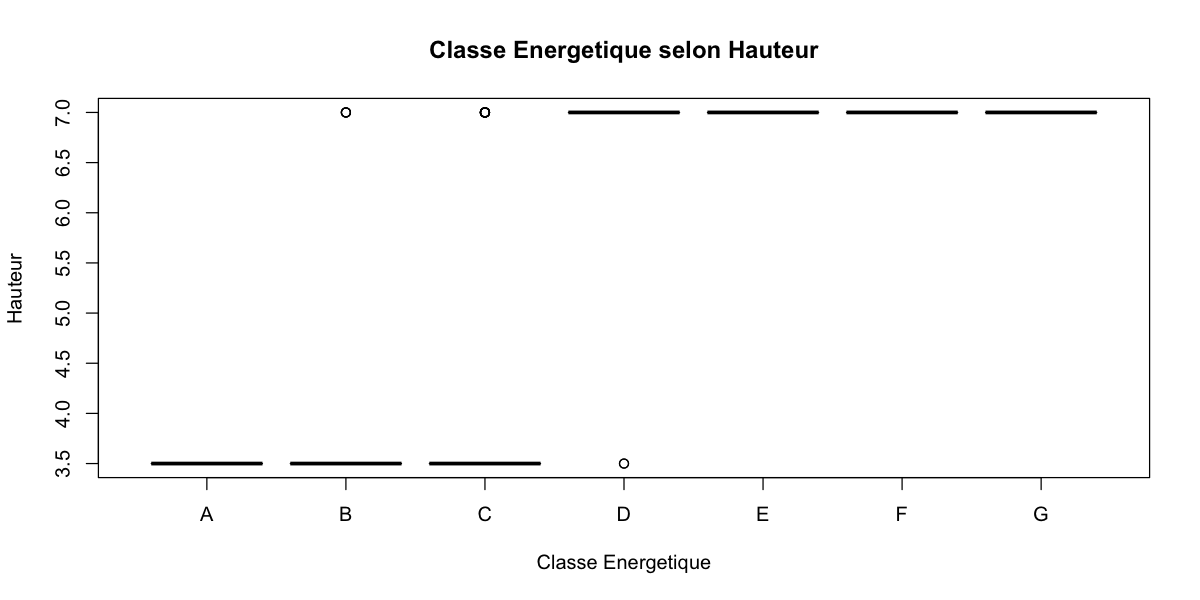

In [28]:
options(repr.plot.width = 10, repr.plot.height = 5) 
boxplot(x$Overall.height~ x$Energy.efficiency, main ="Classe Energetique selon Hauteur", xlab="Classe Energetique", ylab="Hauteur",col='red')

On remarque sur ce graphique que les classes A, B et C ont une hauteur de 3m50 tandis que les classes D, E, F et G ont une hauteur plus élevé (7m).

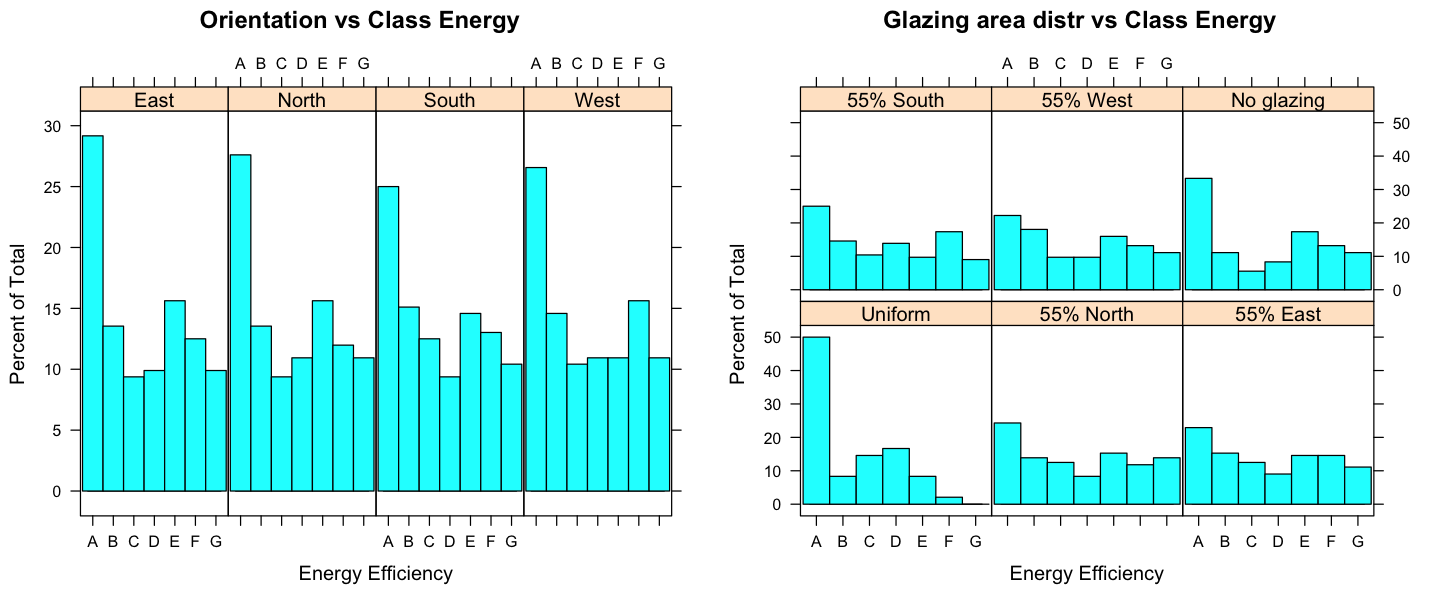

In [29]:
options(repr.plot.width = 12, repr.plot.height = 5) 
h1 = histogram(~Energy.efficiency | orientation , data=x, xlab= "Energy Efficiency",main="Orientation vs Class Energy",)
h2 = histogram(~Energy.efficiency | Glazing.area.distr, data=x,main="Glazing area distr vs Class Energy", xlab= "Energy Efficiency")
grid.arrange(h1, h2, nrow=1, ncol=2)
#histogram(~orientation | Energy.efficiency , data=x, xlab= "Energy Efficiency",main="Orientation vs Class Energy",)
#mosaicplot(table2, main="Glazing area distr vs Class Energy")

Les classes d'énergie sont uniformement réparties selon l'orientation du bâtiment et selon l'orientation des vitrages. L'orientation des bâtiments n'influe donc probablement pas l'appartenance à une certaine classe d'énergie.

En revanche, lorsqu'il y a pas de vitrage ou lorsque l'orientation des vitrages est uniforme, la classe A est majoritaire. (Logique, un batiment sans vitrage est mieux isolé)

## 3) Principal Component Analysis :

On enlève la variable Energy car c'est celle qu'on veut prédire.
On garde seulement les variables quantitatives.


**Remarque :** Les variables n'étant pas dans les mêmes unités, nous faisons une ACP réduite.

In [30]:
head(x)

Relative.compactness Wall.area Roof.area Overall.height orientation
1 0.9829276            306.4846  112.0027  7              North      
2 0.9835473            299.7763  110.0480  7              East       
3 0.9794535            303.3744  106.4084  7              South      
4 0.9777325            292.8122  113.0559  7              West       
5 0.9030294            316.2361  118.3664  7              North      
6 0.8909102            314.9162  121.8437  7              East       
  Glazing.area Glazing.area.distr Energy   Energy.efficiency
1 1.609490e-02 Uniform            34.26394 B                
2 1.451379e-02 Uniform            34.58975 B                
3 2.247933e-02 Uniform            38.77805 C                
4 9.554434e-06 Uniform            37.94781 C                
5 2.066201e-02 Uniform            47.67586 D                
6 1.574394e-02 Uniform            41.90847 C

In [31]:
X_acp <- dplyr::select(x,c(Relative.compactness, Roof.area, Wall.area,Overall.height, Glazing.area,Energy.efficiency))
head(X_acp)

Relative.compactness Roof.area Wall.area Overall.height Glazing.area
1 0.9829276            112.0027  306.4846  7              1.609490e-02
2 0.9835473            110.0480  299.7763  7              1.451379e-02
3 0.9794535            106.4084  303.3744  7              2.247933e-02
4 0.9777325            113.0559  292.8122  7              9.554434e-06
5 0.9030294            118.3664  316.2361  7              2.066201e-02
6 0.8909102            121.8437  314.9162  7              1.574394e-02
  Energy.efficiency
1 B                
2 B                
3 C                
4 C                
5 D                
6 C

In [32]:
res.pca <- PCA(X_acp, scale.unit=TRUE, quali.sup=6, graph = FALSE)

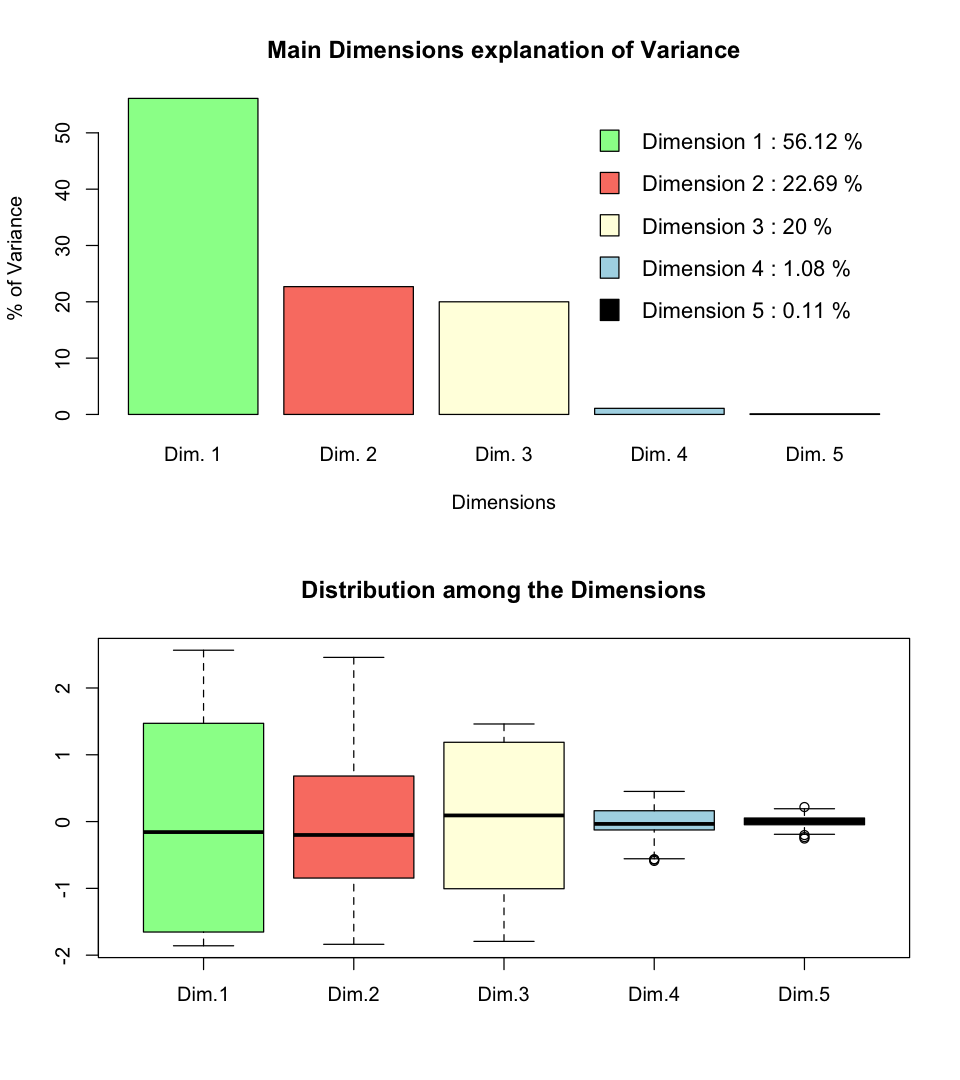

In [33]:
#fviz_eig(res.pca, addlabels = TRUE, ylim = c(0, 50), new.plot=FALSE, graph.type="classic")
lbls = paste("Dimension",1:5, ":", round(res.pca$eig[,2],2), "%" )
coul = c('palegreen','salmon','lightyellow','lightblue','black')
options(repr.plot.width = 8, repr.plot.height = 9) 
par(mfrow=c(2,1))
barplot(res.pca$eig[,2],names.arg=paste("Dim.",1:nrow(res.pca$eig)), xlab="Dimensions", ylab = "% of Variance", col = coul,main="Main Dimensions explanation of Variance")
legend(x='topright',legend=lbls, fill= coul, bty='n', cex=1.1, text.font=0.5)
boxplot(res.pca$ind$coord, outlier=TRUE, col=coul, main = "Distribution among the Dimensions")

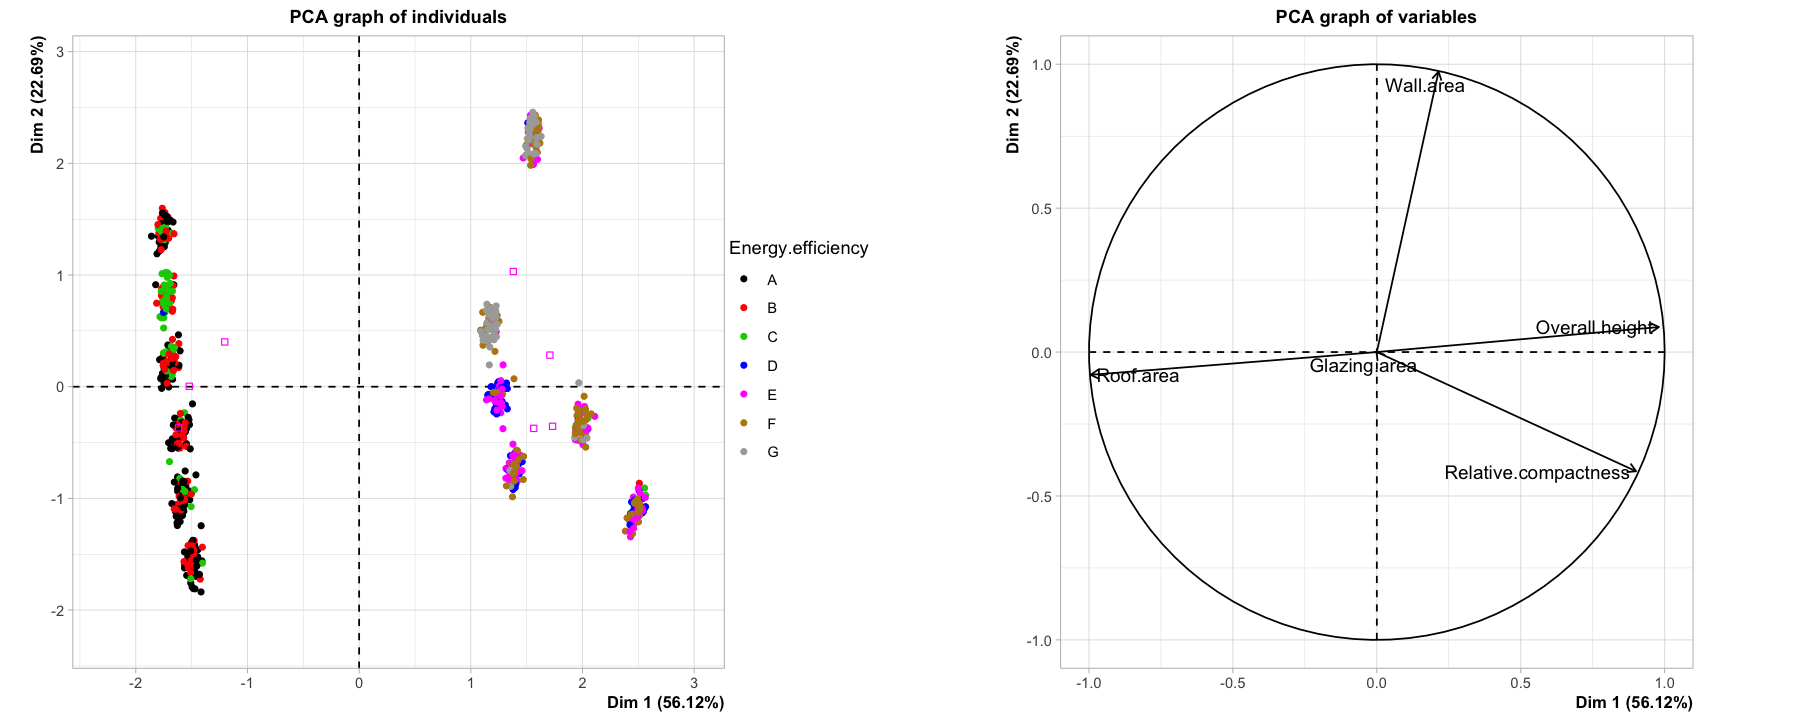

In [34]:
options(repr.plot.width = 15, repr.plot.height = 6) 
plot1 <- plot(res.pca,choix="ind", label="none", new.plot=FALSE, graph.type="ggplot",habillage=6)
plot2 <- plot(res.pca,choix="var", new.plot=FALSE, graph.type="ggplot")
grid.arrange(plot1, plot2, nrow=1, ncol=2)

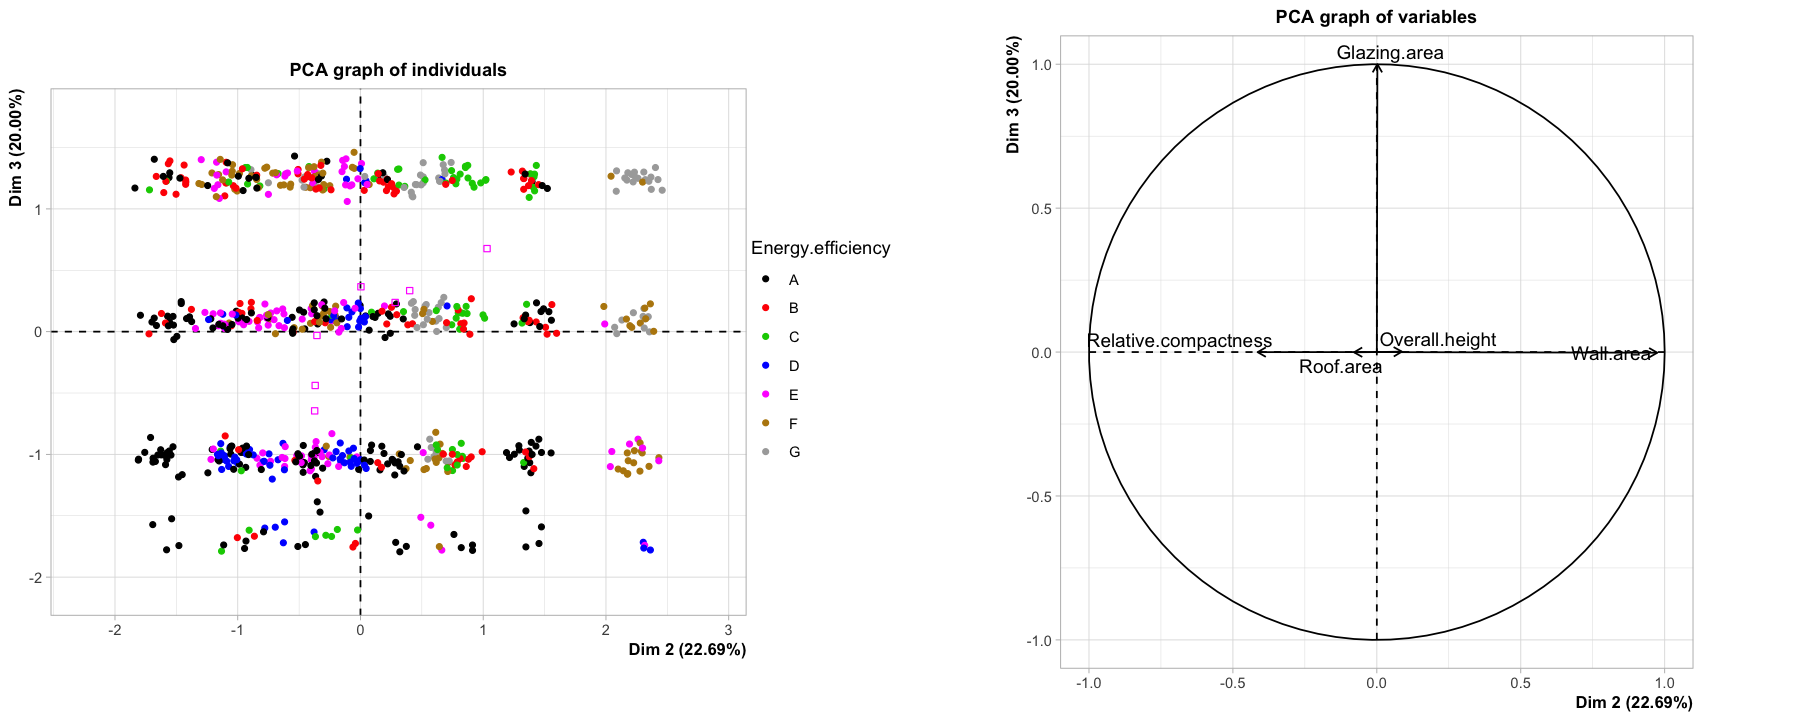

In [35]:
options(repr.plot.width = 15, repr.plot.height = 6) 
plot3 <- plot(res.pca,axes=c(2,3),choix="ind", label="none", new.plot=FALSE, graph.type="ggplot",habillage=6)
plot4 <- plot(res.pca,axes=c(2,3),choix="var", new.plot=FALSE, graph.type="ggplot")
grid.arrange(plot3, plot4, nrow=1, ncol=2)

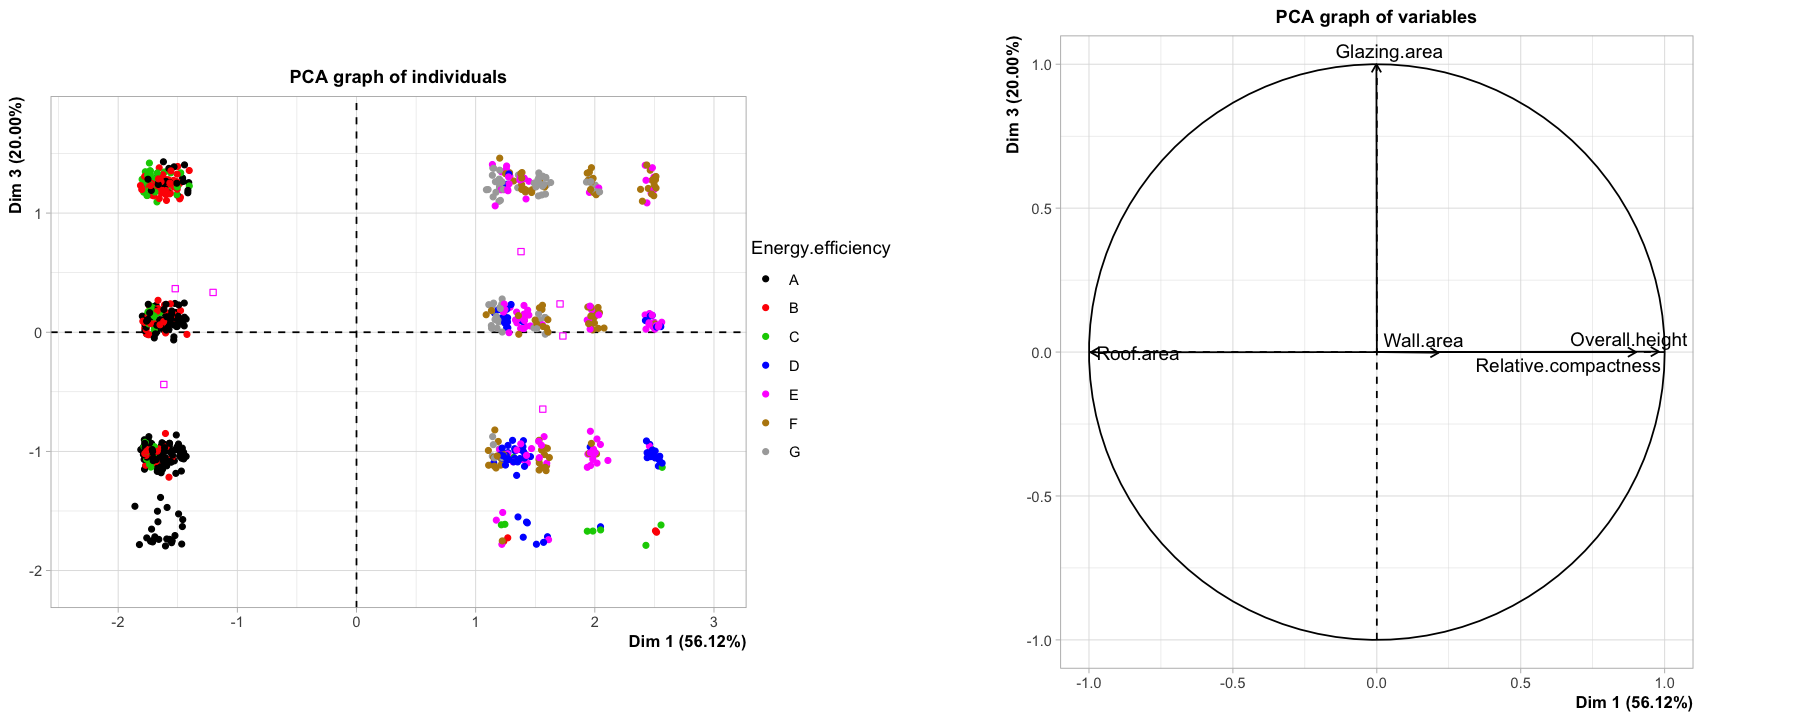

In [36]:
options(repr.plot.width = 15, repr.plot.height = 6) 
plot5 <- plot(res.pca, axes=c(1,3), choix="ind", label="none", new.plot=FALSE, graph.type="ggplot",habillage=6)
plot6 <- plot(res.pca, axes=c(1,3),choix="var", new.plot=FALSE, graph.type="ggplot")
grid.arrange(plot5, plot6, nrow=1, ncol=2)

**Interprétation** :

cf question énoncé

Partie 4 : Technique de clustering (non-supervisé) :
- K-means clustering


## 4) Clustering 

In [37]:
### k-means avec 7 clusters
x_num=dplyr::select(x, Relative.compactness, Wall.area,Roof.area,Overall.height, Glazing.area)
x_num_cr=scale(x_num)

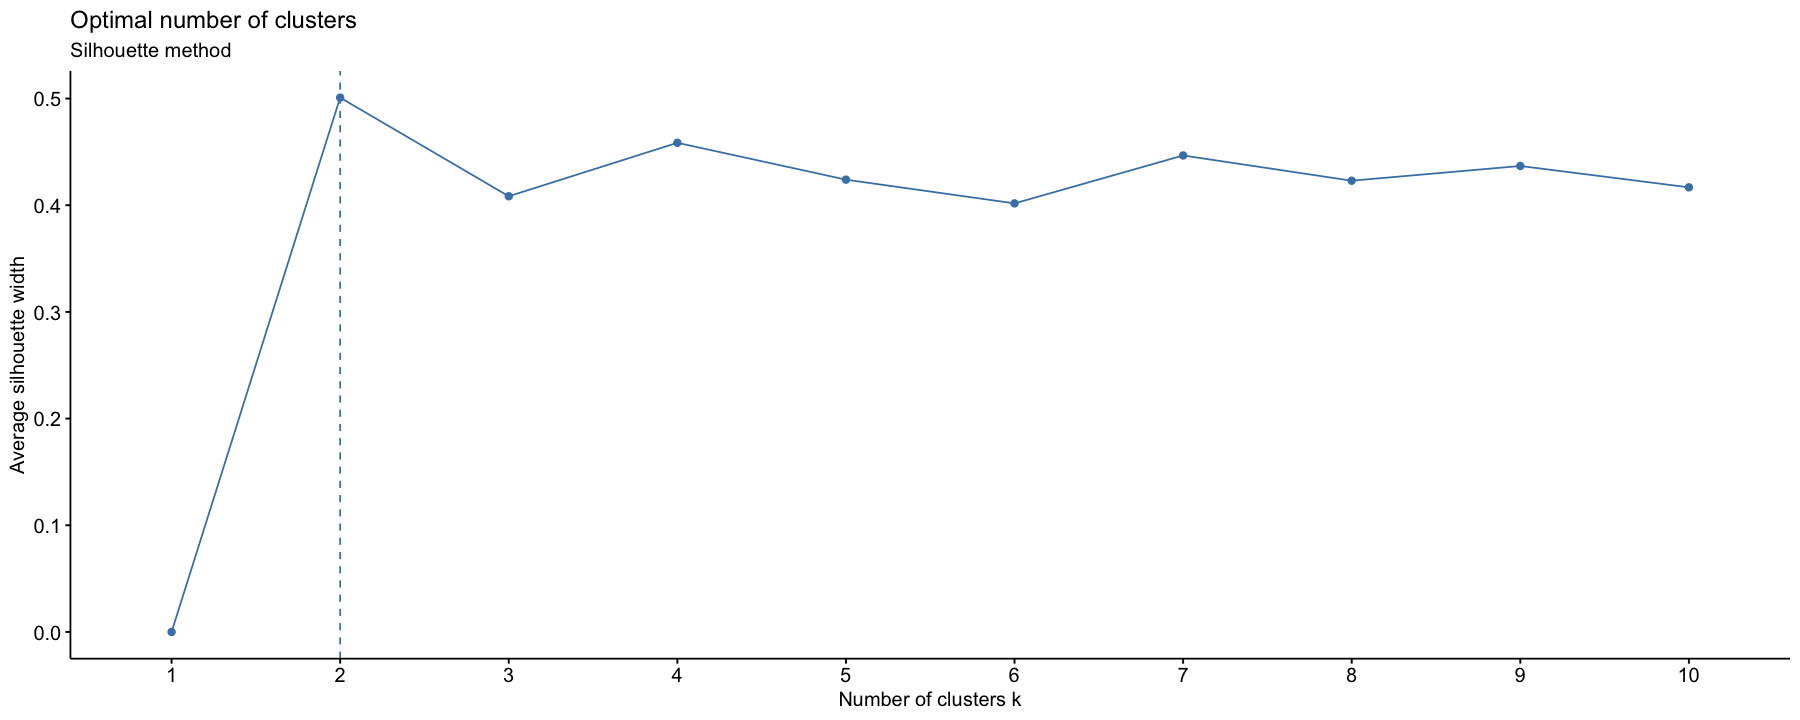

In [38]:
## Recherche du k optimum
# Silhouette method
fviz_nbclust(x_num_cr, kmeans, method = "silhouette")+
labs(subtitle = "Silhouette method")

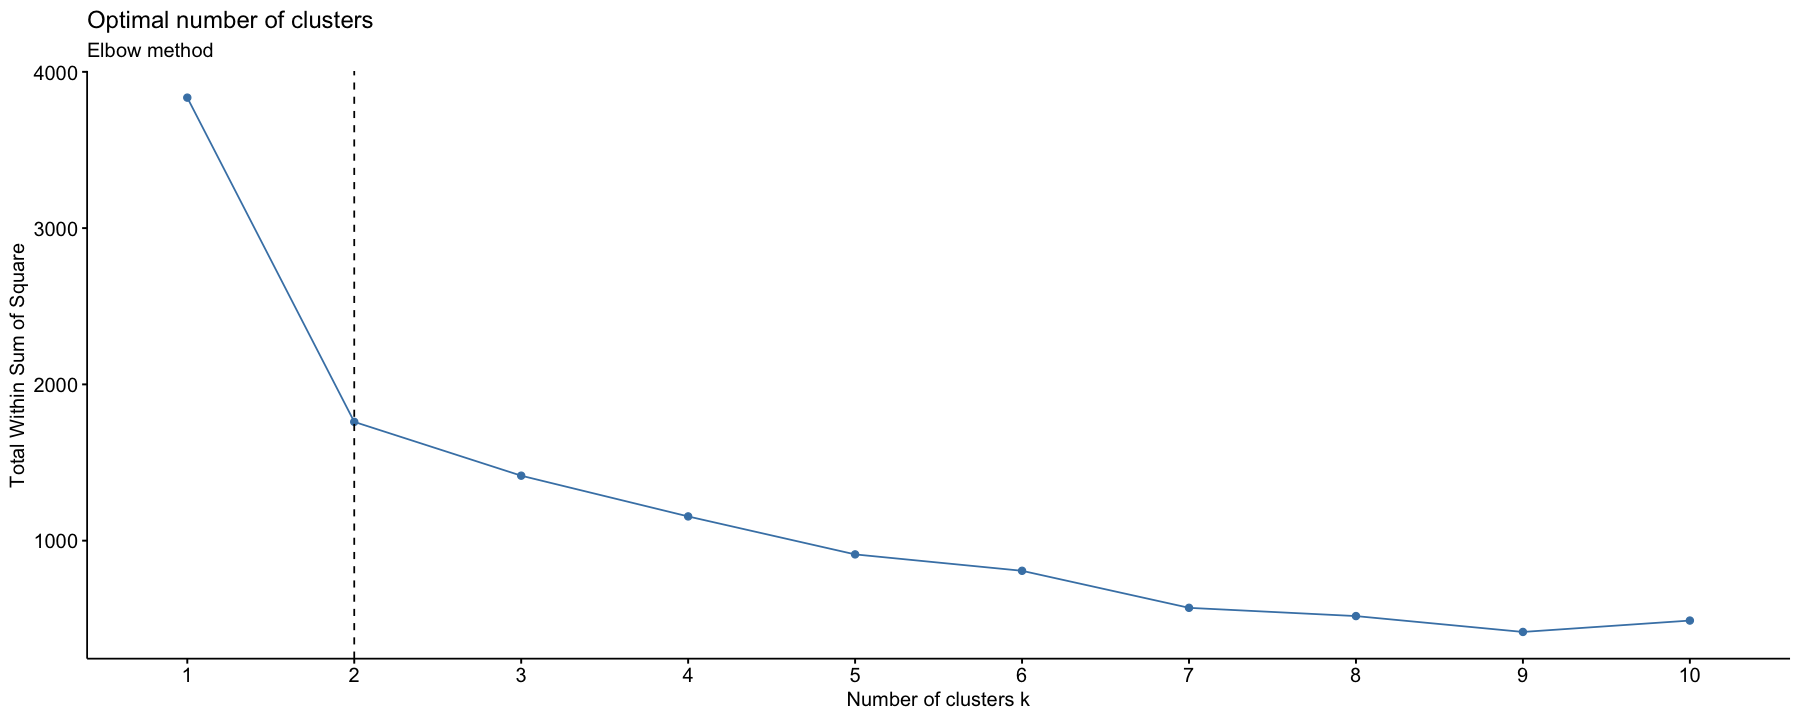

In [39]:
# Elbow method
fviz_nbclust(x_num_cr, kmeans, method = "wss") +
    geom_vline(xintercept = 2, linetype = 2)+
  labs(subtitle = "Elbow method")

Ces deux méthodes nous suggèrent 2 clusters, or on aimerait qu'il y en ai 7 (correspondant aux 7 classes énergétiques)

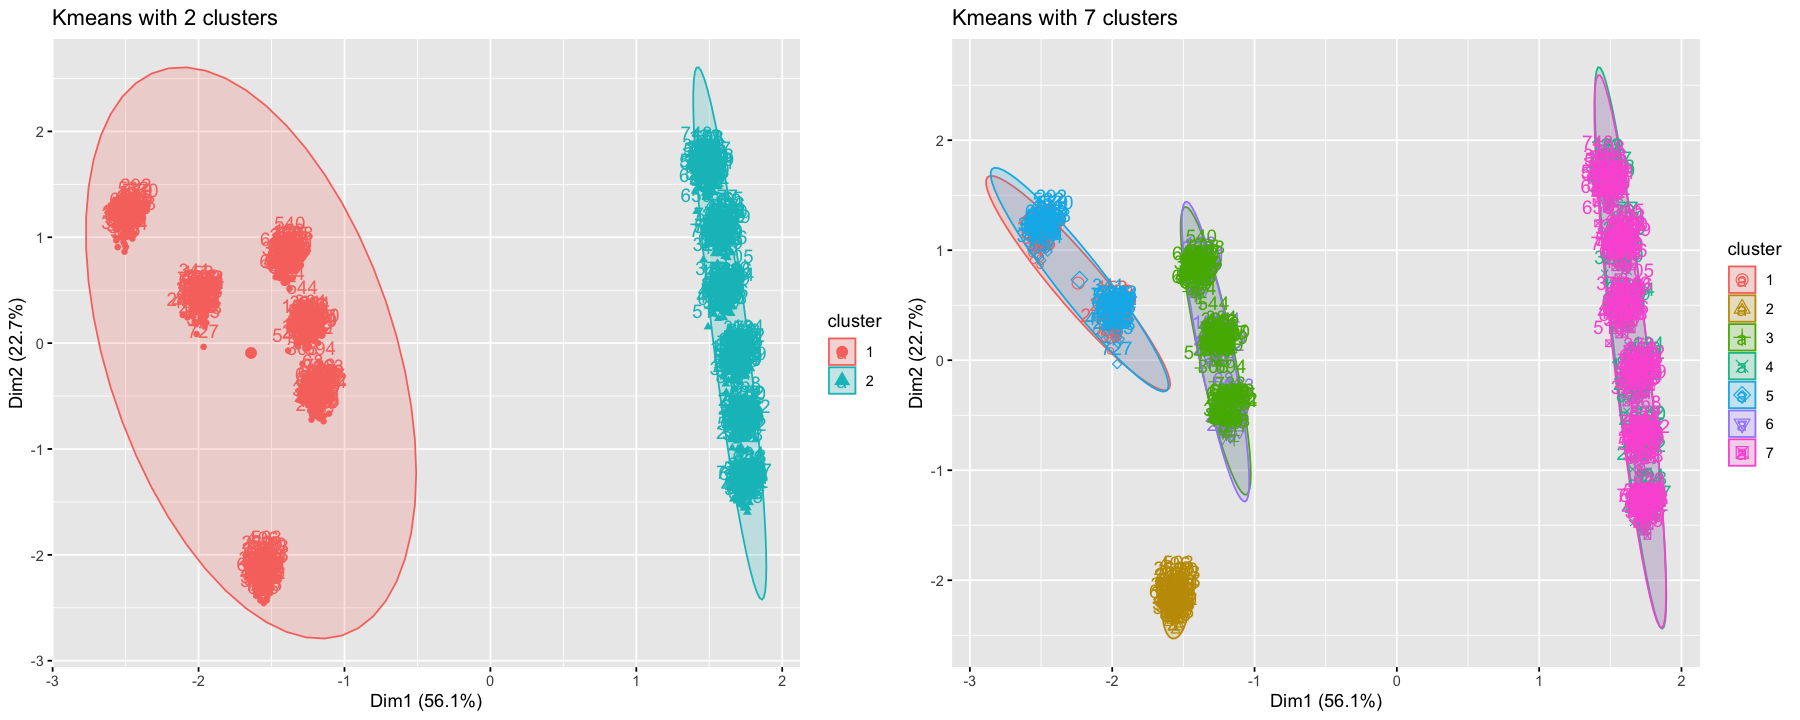

In [40]:
km.out2 = kmeans(x_num_cr,centers=2)
km.out7 = kmeans(x_num_cr,centers=7)
plot.kmean2<-fviz_cluster(km.out2, x_num_cr, ellipse.type = "norm", main='Kmeans with 2 clusters')
plot.kmean7<-fviz_cluster(km.out7, x_num_cr, ellipse.type = "norm", main='Kmeans with 7 clusters')
grid.arrange(plot.kmean2, plot.kmean7, nrow=1, ncol=2)

In [41]:
cat('Table de contingence avec 2 clusters :')

print(table(km.out2$cluster,x$Energy.efficiency))

cat(' \n\n ')
cat('Table de contingence avec 7 clusters :')
print(table(km.out7$cluster,x$Energy.efficiency))

Table de contingence avec 2 clusters :   
      A   B   C   D   E   F   G
  1   0   4  11  77 109 102  81
  2 208 105  69   2   0   0   0
 

 Table de contingence avec 7 clusters :   
      A   B   C   D   E   F   G
  1   0   2   7  18  18   3   0
  2   0   0   0   3   8  25  28
  3   0   0   0  19  40  22  39
  4 114  19  11   0   0   0   0
  5   0   0   0   5  29  39   7
  6   0   2   4  32  14  13   7
  7  94  86  58   2   0   0   0


kmeans ne semble pas adapté à notre problème. Cependant, cet algorithme suggère de regrouper les classes A,B et C ensemble ainsi que D,E,F,G (bonne consommation et mauvaise consommation).

**Pour la suite, il va donc sembler intéressant de faire un premier algorithme réalisant une regresion logistique binaire : Bonne consommation Energétique (A,B,C) vs Mauvaise Consommation Energétique (D,E,F,G) puis, sur ces nouveaux sous-datasets prédits, de mettre en place un modèle de prédiction plus fin.**

# C- Séparation des données :

In [42]:
## 75% of the sample size
train_ratio=0.75
smp_size <- floor(train_ratio * nrow(x))

## set the seed to make your partition reproducible
set.seed(2512)
train_ind <- sample(seq_len(nrow(x)), size = smp_size)

x_train <- x[train_ind, ]
x_test <- x[-train_ind, ]

# D - Modèles :

**Pour évaluer les performances d'un modèle de classification, il faut définir des mesures traduisant son efficacité:**

In [43]:
#Première mesure intuitive : Quotient entre les biens prédits le nombre total de prédictions :
perf_model <- function(table_contingence){
    return( sum(diag(table_contingence))/sum(table_contingence))
}

Le défaut de cette première métrique est qu'elle ne prend pas en compte l'écart de classe quand on se trompe. En effet,imaginons que la vraie valeur soit la classe A ; l'erreur est bien plus grave si on prédit une consommation de type G que si l'on prédit une consommation de type B.

L'idée est alors de mettre en place une métrique prenant en compte cet écart de classe dans la prédiction.

In [44]:
perf_model_clever <- function(table){
    L = nrow(table)
    #Creation de la matrice de poids:
    W = table #initialisation pour avoir la meme shape
    
    for (ligne in 1:L){
        #remplissage de la lower triangular partie
        for (col in 1:ligne){
           W[ligne, col]=ligne-col
        }
        #remplissage de la upper triangular partie
        for (col in ligne:L){
            W[ligne,col] = col-ligne
        }
    }
    
    #on a maintenant notre matrice de poids, on l'applique à nos résultats : 
    table_erreur_ponder <- table*W #contient des 0 sur la diagonale pour ne tenir compte que des erreurs
    taux_erreur = sum(table_erreur_ponder)/(sum(W))
    score_perf = 1- taux_erreur
    return(score_perf)
}






In [45]:
#Definition des tableaux de score :
Tab_score_class = as.data.frame(setNames(replicate(3,numeric(0), simplify = F),c("Modele","Score1","Score2 ") ))
Tab_score_reg = as.data.frame(setNames(replicate(4,numeric(0), simplify = F),c("Modele","Score1","Score2", "RMSE") ))

#Function to automatically compute and display errors from a model prediction : 

#pred est la liste des prédictions sur le jeu de test
#quali est le type de la prediction

Compute_Error <- function(pred,quali=TRUE, name_model=""){ 
    
    if (quali){
        table_result = table(pred.reg = pred , observations = x_test$Energy.efficiency)
        cat("Table de contingence de", name_model, ": \n")
        print(table_result)
        score1 = perf_model(table_result)
        score2 = perf_model_clever(table_result)
        to_add <- data.frame(Modele=name_model, Score1=score1,Score2=score2) #on cree une df avec les mêmes noms de colonnes
        Tab_score_class = rbind(Tab_score_class,to_add) # on concatène ensuite
        return(Tab_score_class)
    }
    else{
        pred_class <- classify(pred)   
        table_result = table(pred.reg = pred_class , observations = x_test$Energy.efficiency)
        cat("Table de contingende de", name_model, ": \n")
        print(table_result)
        score1 = perf_model(table_result)
        score2 = perf_model_clever(table_result)
        rmse = sqrt( sum( (pred - x_test_reg$Energy)^2 ) /nrow(x_test_reg) )
        to_add <- data.frame(Modele=name_model, Score1=score1,Score2=score2, RMSE=rmse) #on cree une df avec les mêmes noms de colonnes
        Tab_score_reg = rbind(Tab_score_reg,to_add) # on concatène ensuite
        return(Tab_score_reg)        
        
    }
    
    
}

## 1) Premier point de vue :  Classification

In this part we focus only on the classification problem, which is to predict in which energy Efficiency class an individual will be. Therefore, we remove the Variable Energy in this part.

In [201]:
x_train_class <- dplyr::select(x_train, Relative.compactness, Wall.area,Roof.area,Overall.height,orientation, Glazing.area,Glazing.area.distr,Energy.efficiency)
x_test_class <- dplyr::select(x_test, Relative.compactness, Wall.area,Roof.area,Overall.height,orientation, Glazing.area,Glazing.area.distr,Energy.efficiency)

### a) Régression Logistique Polythomiale : 

We are going to perform a polynomial orderded logistic regression also known as polythomial regression.

There are tow ways of doing so : additive logits and adjacents logits.

We first define a simple model that we call **m0**.

**Mise en place du modèle:**

In [202]:
#Additive Simple: 
m0 <- vglm(Energy.efficiency ~., data=x_train_class, family=cumulative(parallel=T, reverse=F))

**Résultats :**

In [203]:
p <- predict(m0, newdata = x_test_class, type = "response") #matrice de proba d'appartenance à chaque classe
prediction <- apply(p,1, which.max) 
Tab_score_class <-Compute_Error(prediction,quali=TRUE,name_model = "Naive Logit");Tab_score_class

Table de contingence de Naive Logit : 
        observations
pred.reg  A  B  C  D  E  F  G
       1 38  9  5  0  0  0  0
       2  4 13  7  1  0  0  0
       3  3  3 12  1  0  0  0
       4  0  1  1  9  7  0  0
       5  0  0  1  8 14 10  1
       6  0  0  0  2  6 15  5
       7  0  0  0  2  2  2 10


Modele             Score1    Score2    
1 Naive Logit        0.5781250 0.09821429
2 Tree opti          0.6302083 0.28571429
3 Random Forest      0.6458333 0.34821429
4 Random Forest Opti 0.6458333 0.35714286
5 SVM cost           0.6093750 0.13392857
6 Naive Logit        0.5781250 0.09821429

**Commentaire :** 

Le score de classification est relativement faible, cependant, les erreurs de classification sont majoritairement dans les classes voisines.

In [204]:
# A DEMANDER AU PROF SI ON UTILISE LES 2 METHODES 
#Adjacents simple: 
#m0_c <- vglm(Energy.efficiency ~., data=x_train_reg, family=acat(parallel=F, reverse=F))
#p <- predict(m0_c, newdata = x_test_reg, type = "response")
#prediction <- apply(p,1, which.max)
#result2 = table(pred.reg = prediction,observations = x_test_reg$Energy.efficiency); result2
#score_logit_2 = sum(diag(result2))/sum(result2); score_logit_2

In [205]:
# A LA MAIN DE MAX
#proba_m0_cumul = exp(m0@predictors)/(1+exp(m0@predictors))
#head(proba_m0_cumul) #attention ne pas tenir compte de l'en tête pour la sortie de cette commande,
#la vraie en-tête devrait juste être : P(Y<=1) P(Y<=2) ... P(Y<=6) P(Y<=7)
#La commande ne sort pas la dernière en tête car elle vaut tout simplement 1 - P(Y<=6)
#on calcule maintenant les probas d'être dans chaque classe :
#proba_m0 <- proba_m0_cumul[,1]
#M = dim(proba_m0_add_cumul)[2]
#for (j in seq(1,M-1)){
#proba_m0 <- cbind(proba_m0,proba_m0_cumul[,j+1]-proba_m0_cumul[,j])
#}
#proba_m0 <- cbind(proba_m0, (1-proba_m0_cumul[,M]))

### FAIRE METHODE CECILE ???

### b) Regression Logistique Pénalisée : 

In [206]:
install.packages("pmlr") #Demander au prof car pas beaucoup de solutions de ce coté là..

Warning message:
“package ‘pmlr’ is not available (for R version 3.6.1)”


**Mise en place du modèle :**

**Résultats :**

### c) Arbre de regression : 

**Mise en place du modèle :**

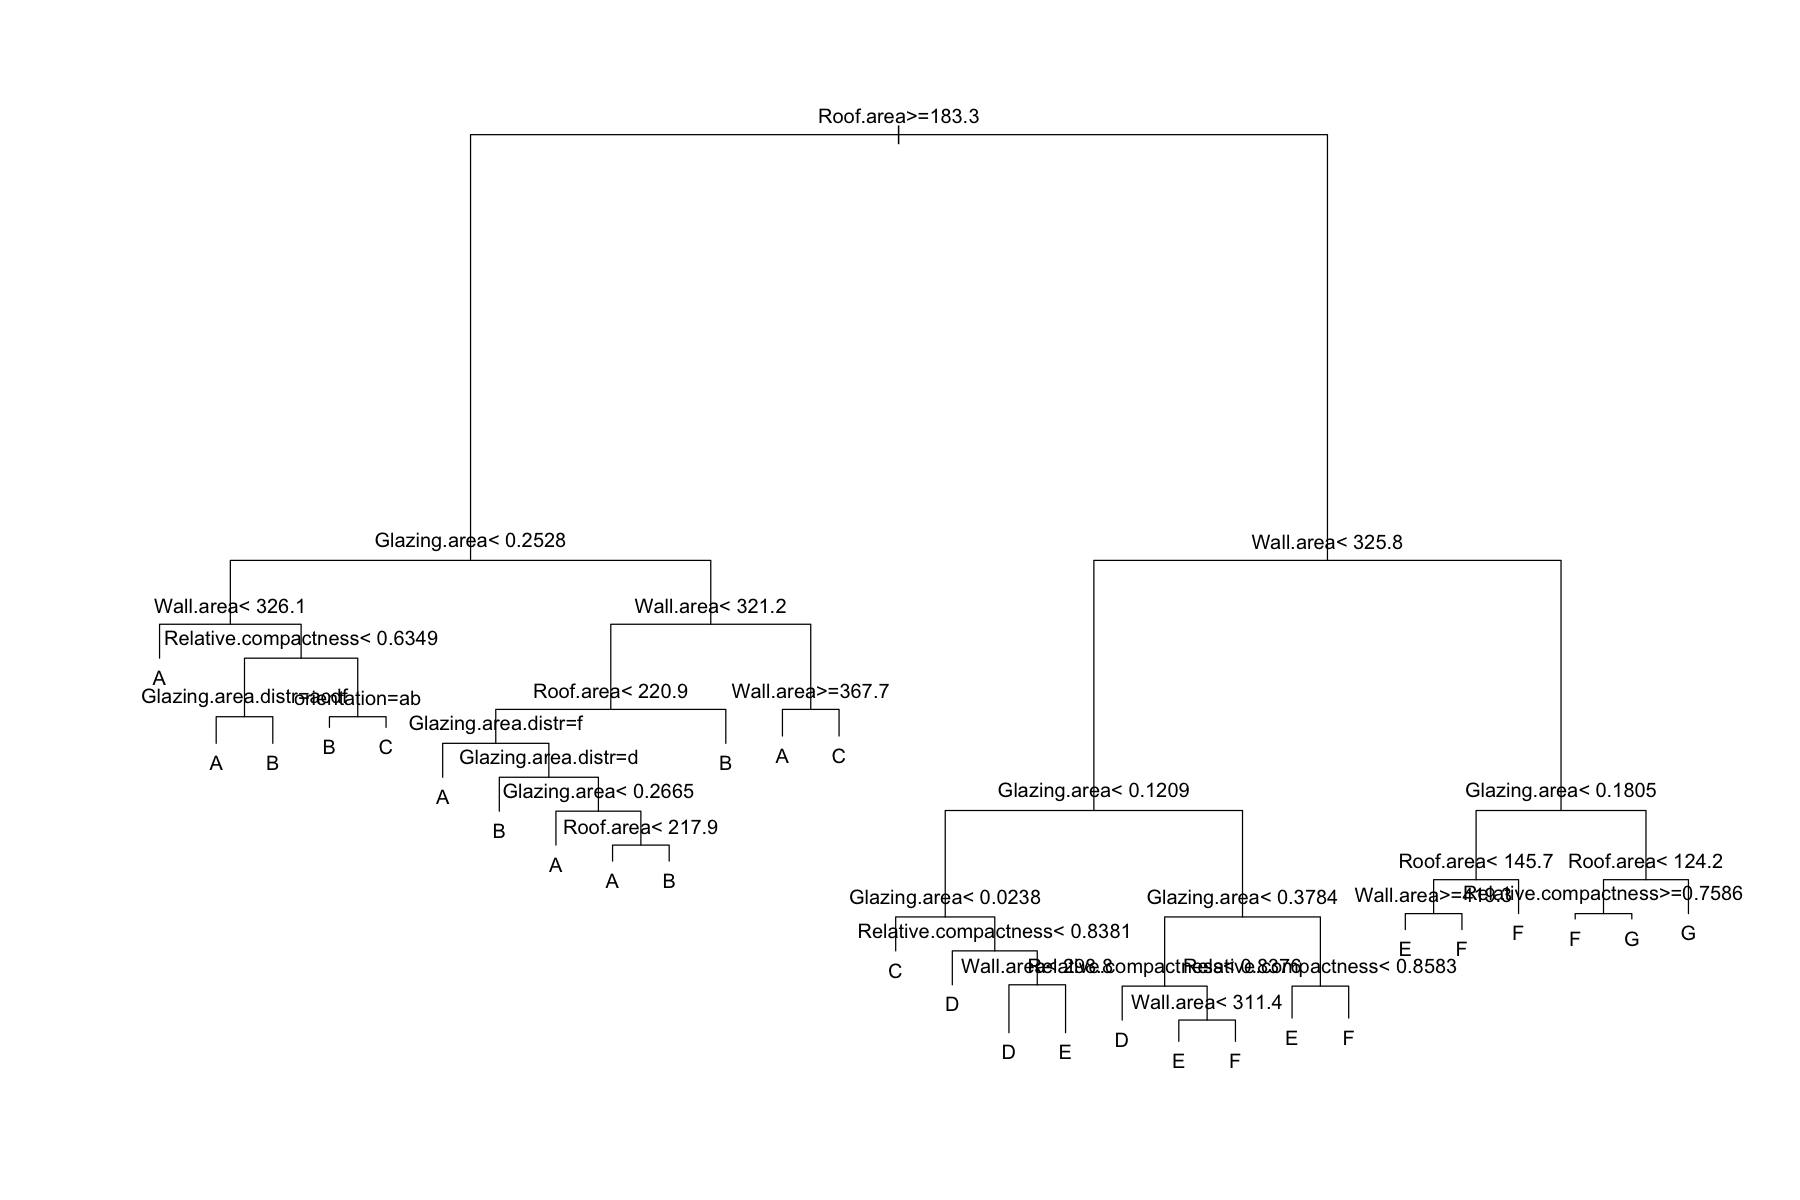

In [207]:
options(repr.plot.width = 15, repr.plot.height = 10)
tree.c=rpart(Energy.efficiency~.,data=x_train_class,control=rpart.control(cp=0.001))
# La commande ci-dessous fournit un descriptif de l'arbre obtenu

plot(tree.c)
text(tree.c)

On voit sur ce premier arbre que la variable Roof.area a une très grande influence sur la classification énergétique. 

Déterminons maintenant le meilleur paramètre de complexité (cp) qui a pour but d'élaguer l'arbre.

cp opti : 0.006848492

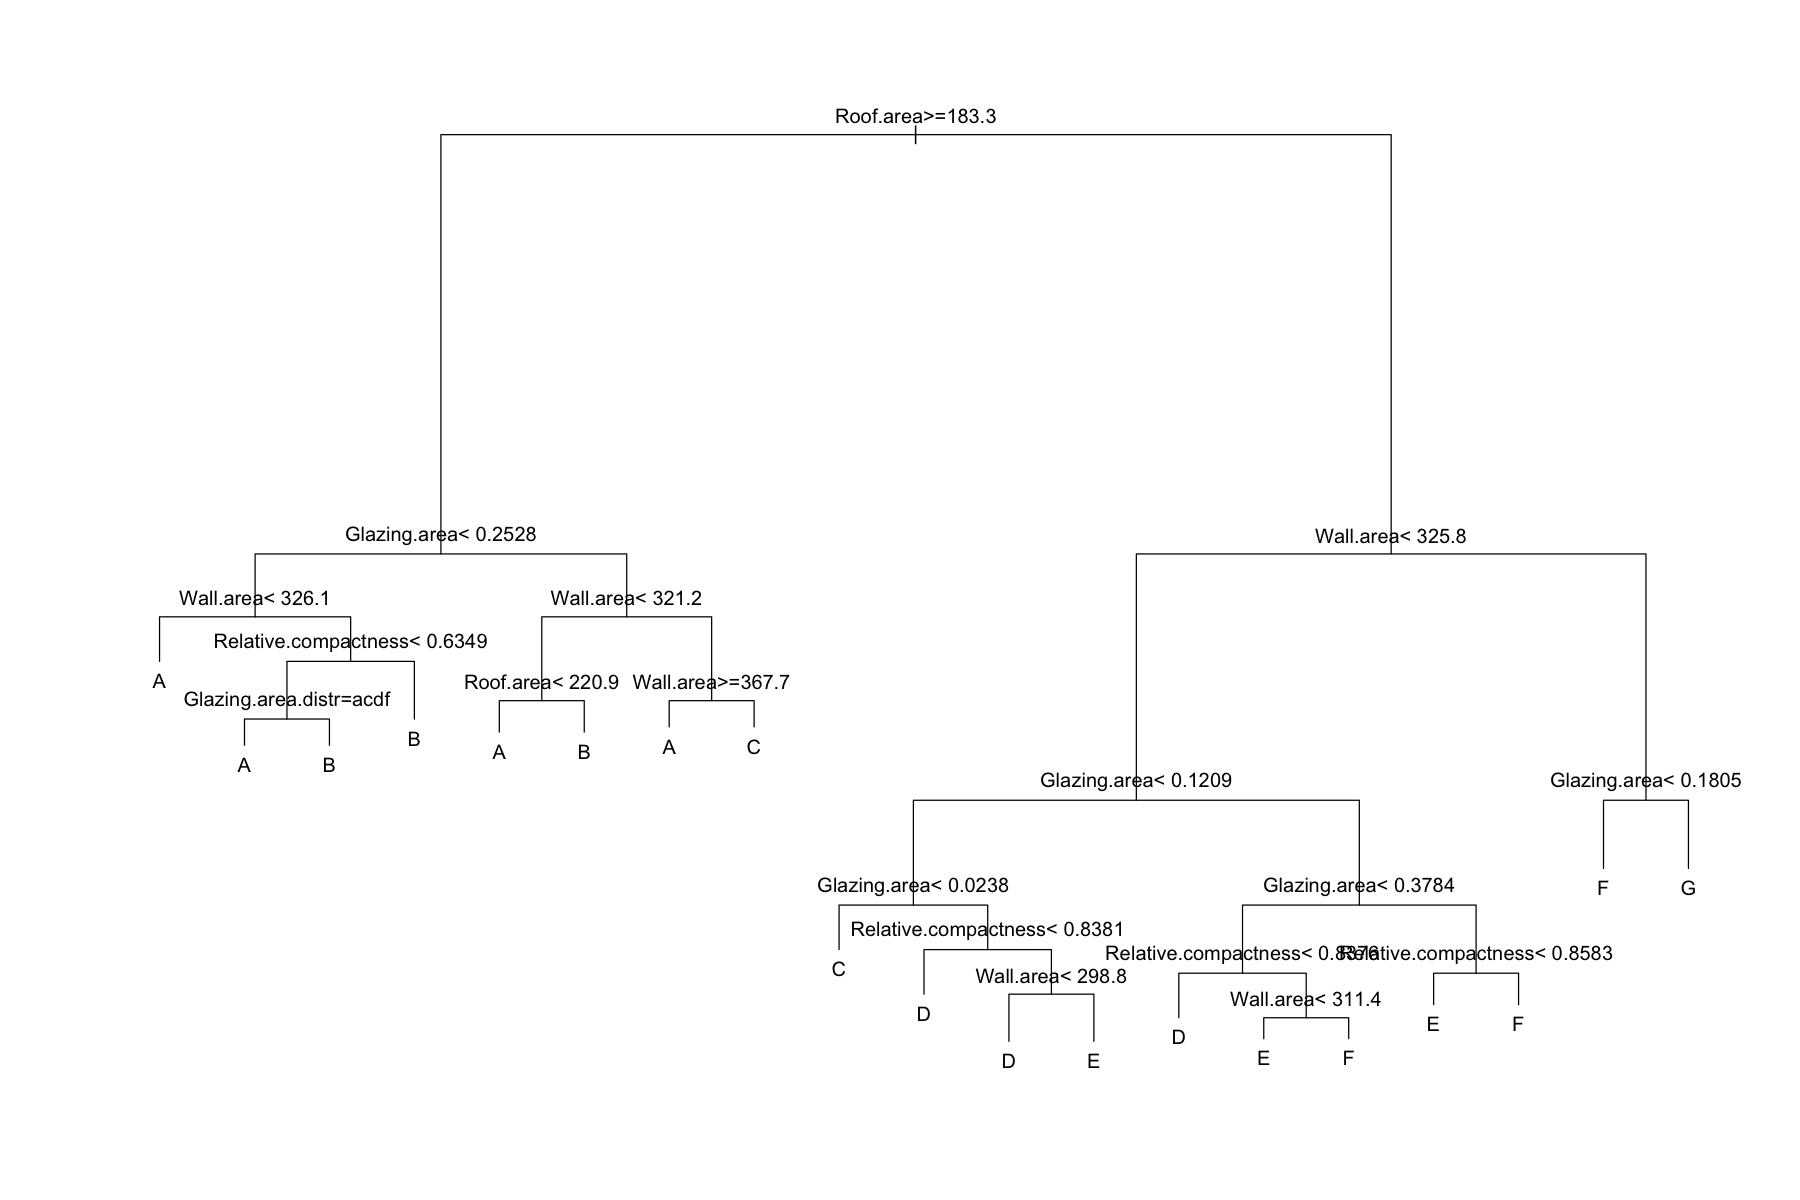

In [208]:
xmat=xpred.rpart(tree.c, xval = 10)
#levels(datappr[,"Survived"]) <- c(1,2)
xerr <- (xmat-as.numeric(x_train_class[, "Energy.efficiency"]))^2
CVerr=apply(xerr,2,sum)
#CVerr  #    CP           erreur
cp_opti = as.numeric(attributes(which.min(CVerr))$names); 

cat('cp opti :', cp_opti)

tree.opti=rpart(Energy.efficiency~.,data=x_train_class,control=rpart.control(cp=cp_opti))
options(repr.plot.width = 15, repr.plot.height = 10)
plot(tree.opti)
text(tree.opti)

**Commentaire :**
On remarque que la variable Roof.Area permet déja de classifier les extrêmes (classe A,B vs D,E,F,G), la délimitation dela classe C n'étant pas aussi nette.

**Résultats :**

In [209]:
p <- predict(tree.opti, newdata = x_test_class, type = "class")
Tab_score_class <-Compute_Error(p,quali=TRUE,name_model = "Tree opti");Tab_score_class
#tab2 = table(p, x_test_class[, "Energy.efficiency"]); tab2
#score_tree_opti_class = sum(diag(tab2)) / sum(tab2)
#cat("Score de Classification : ",score_tree_opti_class)

#On actualise le tableau des scores
#Tab_score = c(Tab_score,score_tree_opti_class)
#Name_model = c(Name_model, "Tree Opti")

Table de contingence de Tree opti : 
        observations
pred.reg  A  B  C  D  E  F  G
       A 32 10  6  0  0  0  0
       B 11 10  6  0  0  0  0
       C  2  6 13  2  0  0  0
       D  0  0  1 13  3  0  0
       E  0  0  0  7 19  6  0
       F  0  0  0  1  6 19  2
       G  0  0  0  0  1  2 14


Modele             Score1    Score2    
1 Naive Logit        0.5781250 0.09821429
2 Tree opti          0.6302083 0.28571429
3 Random Forest      0.6458333 0.34821429
4 Random Forest Opti 0.6458333 0.35714286
5 SVM cost           0.6093750 0.13392857
6 Naive Logit        0.5781250 0.09821429
7 Tree opti          0.6250000 0.26785714

### d) Random Forest : 

**Mise en place du modèle :**

In [210]:
set.seed(69)
rf <- randomForest(Energy.efficiency ~ ., data = x_train_class, 
                       xtest = x_test_class[,-c(8)], ytest = x_test_class[,"Energy.efficiency"],
                       ntree = 500,do.trace = 50, importance = TRUE)


ntree      OOB      1      2      3      4      5      6      7|    Test      1      2      3      4      5      6      7
   50:  39.93% 14.11% 63.86% 61.11% 35.71% 53.75% 49.33% 32.31%|  32.81% 17.78% 57.69% 53.85% 39.13% 24.14% 37.04%  0.00%
  100:  39.24% 14.11% 60.24% 55.56% 39.29% 51.25% 52.00% 32.31%|  34.38% 17.78% 69.23% 53.85% 39.13% 24.14% 33.33%  6.25%
  150:  39.06% 12.27% 61.45% 57.41% 35.71% 51.25% 57.33% 29.23%|  34.90% 17.78% 69.23% 53.85% 39.13% 27.59% 33.33%  6.25%
  200:  38.19% 10.43% 60.24% 55.56% 33.93% 51.25% 58.67% 29.23%|  34.90% 20.00% 69.23% 50.00% 34.78% 27.59% 37.04%  6.25%
  250:  38.54% 12.27% 62.65% 57.41% 35.71% 48.75% 54.67% 29.23%|  34.38% 17.78% 69.23% 50.00% 39.13% 27.59% 33.33%  6.25%
  300:  37.67% 12.27% 60.24% 55.56% 35.71% 50.00% 50.67% 29.23%|  34.38% 17.78% 65.38% 50.00% 39.13% 31.03% 33.33%  6.25%
  350:  37.85% 12.27% 56.63% 53.70% 37.50% 48.75% 57.33% 29.23%|  35.42% 20.00% 69.23% 50.00% 39.13% 31.03% 33.33%  6.25%
  400:  38.02% 12.27% 60

**Résultats :**

In [211]:
pred.rf <- rf$test$predicted
Tab_score_class <-Compute_Error(pred.rf,quali=TRUE,name_model = "Random Forest");Tab_score_class
#tab3 = table(pred.rf, x_test_class[, "Energy.efficiency"]); tab3
#score.randomForest.class = sum(diag(tab3)) / sum(tab3)
#cat("Score de classification : " , score.randomForest.class )

#On actualise le tableau de scores : 
#Tab_score = c(Tab_score,score.randomForest.class)
#Name_model = c(Name_model, "Random Forest")

Table de contingence de Random Forest : 
        observations
pred.reg  A  B  C  D  E  F  G
       A 37  9  2  0  0  0  0
       B  6  9  9  0  0  0  0
       C  2  8 12  1  0  0  0
       D  0  0  3 14  2  0  0
       E  0  0  0  8 20  8  0
       F  0  0  0  0  6 17  1
       G  0  0  0  0  1  2 15


Modele             Score1    Score2    
1 Naive Logit        0.5781250 0.09821429
2 Tree opti          0.6302083 0.28571429
3 Random Forest      0.6458333 0.34821429
4 Random Forest Opti 0.6458333 0.35714286
5 SVM cost           0.6093750 0.13392857
6 Naive Logit        0.5781250 0.09821429
7 Tree opti          0.6250000 0.26785714
8 Random Forest      0.6458333 0.34821429

**Commentaire :** 
Nous remarquons dans un premier temps que le taux de classification est meilleur que tous celui obtenu avec l'arbre de décision.

Pour améliorer le taux de classification de Random Forest, nous pouvons essayer de modifier le paramètre __mtry__ correspondant au nombre de variables testées à chaque division.

Utilisons la librairie caret.


**Mise en place du modèle optimisé:**

In [212]:
set.seed(69)
cvControl <- trainControl(method = "cv", number = 10)
mtryTrials <- train(x_train_class, x_train_class$Energy.efficiency, method = "rf", tuneLength = 6,
               trControl = cvControl, trace = FALSE)
mtryTrials

Random Forest 

576 samples
  8 predictor
  7 classes: 'A', 'B', 'C', 'D', 'E', 'F', 'G' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 519, 518, 520, 521, 515, 518, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
  2     0.9827446  0.9792693
  3     0.9914582  0.9897383
  4     0.9983607  0.9980335
  5     0.9983607  0.9980335
  6     0.9983607  0.9980335
  8     1.0000000  1.0000000

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 8.

In [213]:
set.seed(69)
rf.opti <- randomForest(Energy.efficiency ~ ., data = x_train_class, 
                       xtest = x_test_class[,-c(8)], ytest = x_test_class[,"Energy.efficiency"],
                       ntree = 500,mtry=4,do.trace = 50, importance = TRUE)

ntree      OOB      1      2      3      4      5      6      7|    Test      1      2      3      4      5      6      7
   50:  39.93% 17.18% 59.04% 59.26% 42.86% 45.00% 53.33% 32.31%|  34.38% 15.56% 69.23% 50.00% 39.13% 27.59% 40.74%  0.00%
  100:  38.54% 15.95% 57.83% 55.56% 37.50% 46.25% 53.33% 30.77%|  36.46% 20.00% 73.08% 50.00% 34.78% 31.03% 44.44%  0.00%
  150:  38.37% 15.95% 60.24% 53.70% 32.14% 48.75% 52.00% 30.77%|  35.42% 17.78% 69.23% 50.00% 39.13% 31.03% 40.74%  0.00%
  200:  37.67% 14.72% 62.65% 53.70% 28.57% 47.50% 50.67% 30.77%|  35.42% 20.00% 65.38% 50.00% 39.13% 31.03% 40.74%  0.00%
  250:  37.15% 15.95% 55.42% 53.70% 28.57% 46.25% 53.33% 30.77%|  35.42% 20.00% 69.23% 50.00% 39.13% 31.03% 37.04%  0.00%
  300:  37.15% 14.72% 57.83% 55.56% 30.36% 47.50% 49.33% 30.77%|  35.42% 20.00% 69.23% 53.85% 34.78% 31.03% 37.04%  0.00%
  350:  38.02% 16.56% 56.63% 53.70% 32.14% 47.50% 52.00% 32.31%|  34.90% 20.00% 69.23% 50.00% 34.78% 31.03% 37.04%  0.00%
  400:  37.67% 15.34% 57

**Résultats :**

In [214]:
pred.rf.opti <- rf.opti$test$predicted
Tab_score_class <-Compute_Error(pred.rf.opti,quali=TRUE,name_model = "Random Forest Opti");Tab_score_class

#tab4 = table(pred.rf.opti, x_test_class[, "Energy.efficiency"]); tab4
#score_random_forest_opti = sum(diag(tab4)) / sum(tab4)
#cat("Score de classification : " , score_random_forest_opti )

#Actualisation du tableau de score :
#Tab_score = c(Tab_score,score_random_forest_opti)
#Name_model = c(Name_model, "Random Forest Opti")

Table de contingence de Random Forest Opti : 
        observations
pred.reg  A  B  C  D  E  F  G
       A 36 10  1  0  0  0  0
       B  7  8 11  0  0  0  0
       C  2  8 13  1  0  0  0
       D  0  0  1 15  2  0  0
       E  0  0  0  7 20  8  0
       F  0  0  0  0  6 16  0
       G  0  0  0  0  1  3 16


Modele             Score1    Score2    
1 Naive Logit        0.5781250 0.09821429
2 Tree opti          0.6302083 0.28571429
3 Random Forest      0.6458333 0.34821429
4 Random Forest Opti 0.6458333 0.35714286
5 SVM cost           0.6093750 0.13392857
6 Naive Logit        0.5781250 0.09821429
7 Tree opti          0.6250000 0.26785714
8 Random Forest      0.6458333 0.34821429
9 Random Forest Opti 0.6458333 0.35714286

### e) Boosting 

**Mise en place du modèle :**

In [178]:
library(adabag)

Loading required package: doParallel

Warning message:
“package ‘doParallel’ was built under R version 3.6.2”
Loading required package: parallel



In [182]:
x_train_class$Energy.efficiency

[1] B A G B C F A B A F G G F D D B F G B F A D F A E A G C D B C G C B E F E
 [38] F D A D E F A F A D G B B F F F A A G F D G F B F E C D F B E E A A E F A
 [75] E B F A C F A B G B F F E B G D B F G A E G E E B A A F G A A A A E G A E
[112] A D D B E A C F G B C F F C D A A A A F D A D B F B C B B F A D C G E A E
[149] A C F C E F F G C A C A B A B B B G F A G A F A A F E D C F E C F E D G A
[186] A B A C G E A E C E A F B F E A C D A G A C C A A G A E G B A E B G A G D
[223] C A A E B A E A C E G B A G B A E A A C A B B E G C A G E A F G B C C G D
[260] B A D A A D A A G F D A B F A A E E A A A G C A F C G E D G A D A A C C E
[297] A D G A B C B F B F C G A A F D A C C A A A B G A B A B A A E A D G A A D
[334] E E C B C G G D F B B F B B F B A F A E G F A E A C A F E F A F E A E C A
[371] A A F G B B E A F F A A D E G A A E E E E D F F E E A E A B G A D C F D G
[408] D A E A A A D A D G B B D D B D A A F E B A G C A A C E A A C A B E A A E
[445] B B A C B E G E A E B F D D E E A B E A C A G A G F B A D A A C B G F F F
[482] B A A C A F G B D B A A A B D E C G B F E A A D C G A C D A B F E G F D F
[519] F A E E A D B G A A D A C F A B B E E E G G D A A D G A G B B G E A A B B
[556] F B E E A A D G C E E A B C A B D E D A B
Levels: A < B < C < D < E < F < G

In [183]:
mfinal <- 100
maxdepth <- 5


boost.Class <- boosting(Energy.efficiency ~ ., data=x_train_class, 
                        mfinal=mfinal, coeflearn="Zhu", 
             control=rpart.control(maxdepth=maxdepth))
boost.Class.pred <- predict.boosting(boost.Class, newdata=x_test_class)
boost.Class.pred$confusion
boost.Class.pred$error

Warning message in boosting(Energy.efficiency ~ ., data = x_train_class, mfinal = mfinal, :
“Méthodes incompatibles ("Ops.ordered", "Ops.factor") pour "!="”


ERROR: Error in vardep != flearn: comparaison de ces types non implémentée


In [189]:
#library(bagRboostR)
install.packages('bagRboostR')

Warning message:
“package ‘bagRboostR’ is not available (for R version 3.6.1)”


**Résultats :**

### f) Support Vector Machine (SVM) 

**Mise en place du modèle :**

In [226]:
svm.class=svm(Energy.efficiency~., data=x_train_class, kernel="linear")
pred.svmr=predict(svm.class, newdata=x_test_class, type = "class")
#


#p <- predict(tree.opti, newdata = x_test_class, type = "class")
#Tab_score_class <-Compute_Error(p,quali=TRUE,name_model = "Tree opti");Tab_score_class

**Résultats :**

In [227]:
Tab_score_class <- Compute_Error(pred.svmr,quali = TRUE, name_model = "SVM cost"); Tab_score_class

Table de contingence de SVM cost : 
        observations
pred.reg  A  B  C  D  E  F  G
       A 39 15  8  0  0  0  0
       B  2  7  9  1  0  0  0
       C  4  3  6  0  0  0  0
       D  0  1  3 11 10  4  0
       E  0  0  0  7 12  6  2
       F  0  0  0  2  2 12  1
       G  0  0  0  2  5  5 13


Modele             Score1    Score2     
1  Naive Logit        0.5781250  0.09821429
2  Tree opti          0.6302083  0.28571429
3  Random Forest      0.6458333  0.34821429
4  Random Forest Opti 0.6458333  0.35714286
5  SVM cost           0.6093750  0.13392857
6  Naive Logit        0.5781250  0.09821429
7  Tree opti          0.6250000  0.26785714
8  Random Forest      0.6458333  0.34821429
9  Random Forest Opti 0.6458333  0.35714286
10 SVM cost           0.5156250 -0.06250000
11 SVM cost           0.5156250 -0.06250000
12 SVM cost           0.4895833 -0.22321429
13 SVM cost           0.5208333 -0.09821429

#### Optim du modèle

In [242]:
svm.rad.tune <- tune.svm(Energy.efficiency~., data=x_train_class, type = "C") 
#                         gamma = seq(0.1, 2, by = 0.2), 
#                         cost = c(1, 50, 100, 200, 1000))

In [243]:
summary(svm.rad.tune)


Error estimation of ‘svm’ using 10-fold cross validation: 0.4566243


In [244]:
pred.svmr.opti=predict(svm.rad.tune$best.model, newdata=x_test_class, type = "class")

In [245]:
Tab_score_class <- Compute_Error(pred.svmr.opti, quali = TRUE, name_model = "SVM Opti cost"); 
Tab_score_class

Table de contingence de SVM Opti cost : 
        observations
pred.reg  A  B  C  D  E  F  G
       A 37 15  8  1  0  0  0
       B  8 10 15  0  0  0  0
       C  0  0  0  0  0  0  0
       D  0  1  3 11 10  3  0
       E  0  0  0  7  9  3  0
       F  0  0  0  2  4 18  2
       G  0  0  0  2  6  3 14


Modele             Score1    Score2     
1  Naive Logit        0.5781250  0.09821429
2  Tree opti          0.6302083  0.28571429
3  Random Forest      0.6458333  0.34821429
4  Random Forest Opti 0.6458333  0.35714286
5  SVM cost           0.6093750  0.13392857
6  Naive Logit        0.5781250  0.09821429
7  Tree opti          0.6250000  0.26785714
8  Random Forest      0.6458333  0.34821429
9  Random Forest Opti 0.6458333  0.35714286
10 SVM cost           0.5156250 -0.06250000
11 SVM cost           0.5156250 -0.06250000
12 SVM cost           0.4895833 -0.22321429
13 SVM cost           0.5208333 -0.09821429
14 SVM cost           0.5468750  0.00000000
15 SVM Opti cost      0.5468750  0.00000000
16 SVM Opti cost      0.5156250 -0.06250000
17 SVM Opti cost      0.5156250 -0.06250000

In [237]:
meilleur <- best.svm(Energy.efficiency~., data=x_train_class, type = "C")

In [240]:
pred.meilleur.svm <- predict(meilleur, newdata=x_test_class, type = "class")

In [241]:
Tab_score_class <- Compute_Error(pred.meilleur.svm, quali = TRUE, name_model = "SVM Opti cost"); 
Tab_score_class

Table de contingence de SVM Opti cost : 
        observations
pred.reg  A  B  C  D  E  F  G
       A 37 15  8  1  0  0  0
       B  8 10 15  0  0  0  0
       C  0  0  0  0  0  0  0
       D  0  1  3 11 10  3  0
       E  0  0  0  7  9  3  0
       F  0  0  0  2  4 18  2
       G  0  0  0  2  6  3 14


Modele             Score1    Score2     
1  Naive Logit        0.5781250  0.09821429
2  Tree opti          0.6302083  0.28571429
3  Random Forest      0.6458333  0.34821429
4  Random Forest Opti 0.6458333  0.35714286
5  SVM cost           0.6093750  0.13392857
6  Naive Logit        0.5781250  0.09821429
7  Tree opti          0.6250000  0.26785714
8  Random Forest      0.6458333  0.34821429
9  Random Forest Opti 0.6458333  0.35714286
10 SVM cost           0.5156250 -0.06250000
11 SVM cost           0.5156250 -0.06250000
12 SVM cost           0.4895833 -0.22321429
13 SVM cost           0.5208333 -0.09821429
14 SVM cost           0.5468750  0.00000000
15 SVM Opti cost      0.5468750  0.00000000
16 SVM Opti cost      0.5156250 -0.06250000

### Bilan Classification :  

In [60]:
cat("Bilan des scores de Classification  : \n " )
Tab_score_class

Bilan des scores de Classification  : 
 

Modele             Score1    Score2    
1 Naive Logit        0.5781250 0.09821429
2 Tree opti          0.6302083 0.28571429
3 Random Forest      0.6458333 0.34821429
4 Random Forest Opti 0.6458333 0.35714286

## 2) Regression Problem :  

In this part we now study the regression problem eg.we want to predict the quantitative variable Energy and then we predict the Energy Efficiency with the Thresold.

In [61]:
#New train and test sets : we remove Energy.efficiency
x_train_reg <- dplyr::select(x_train, Relative.compactness, Wall.area,Roof.area,Overall.height,orientation, Glazing.area,Glazing.area.distr,Energy)
x_test_reg <- dplyr::select(x_test, Relative.compactness, Wall.area,Roof.area,Overall.height,orientation, Glazing.area,Glazing.area.distr,Energy)


Nous allons par la suite avoir besoin de cette fonction une fois les consommations energétiques prédites.

In [62]:
#On met dans la classe correspondante la valeur energetique predite
classify <- function(quantitative.predict){
    predict.class = (quantitative.predict)
    predict.class[quantitative.predict <=30] = 'A'
    predict.class[quantitative.predict >30  & quantitative.predict <= 35] = 'B'
    predict.class[quantitative.predict >35  & quantitative.predict <= 45] = 'C'
    predict.class[quantitative.predict >45  & quantitative.predict <= 55] = 'D'
    predict.class[quantitative.predict >55  & quantitative.predict <= 65] = 'E'
    predict.class[quantitative.predict >65  & quantitative.predict <= 75] = 'F'
    predict.class[quantitative.predict > 75] = 'G'   
    return(predict.class)
}

### a) Linear Regression :

**Mise en place du modèle :**

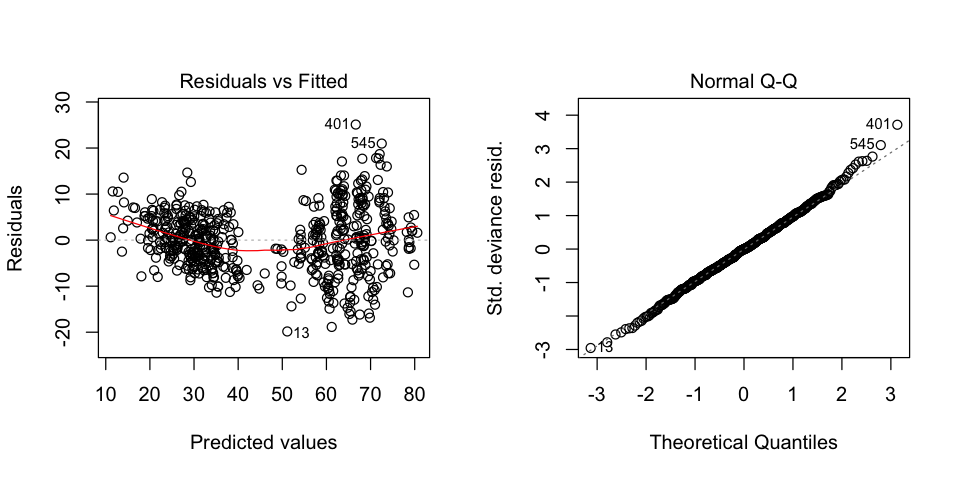

In [63]:
reg.naivelm <- glm(Energy ~., data=x_train_reg)
res.lm <- reg.naivelm$residuals
fit.lm <- reg.naivelm$fitted.values
# graphe des résidus. 
# Définition d'une fonction pour un graphe coloré 
#plot.res <- function(x,y,titre="titre")

#plot(x, y, col = "blue",
#ylab = "Résidus", xlab = "Valeurs prédites", main = titre)
# points(x2, y, col="red")
#abline(h = 0, col = "green")
#}

#options(repr.plot.width = 5, repr.plot.height = 5)
#plot.res(fit.lm,res.lm,"Graphe des Résidus pour la regression naive")
options(repr.plot.width = 8, repr.plot.height = 4) 
par(mfrow=c(1,2))
plot(reg.naivelm, which=1:2)

***Commentaires :***
Le graphe précédent nous permet de visualiser si les hypothèses de linéarité et d'homoscédasticité du modèle.

Les résidus sont centrés mais il semble y avoir une dépendance entre la valeur prédite et l'erreur (quand valeur prédite élevée : erreur forte); graphe en forme de banane.

In [64]:
summary(reg.naivelm)


Call:
glm(formula = Energy ~ ., data = x_train_reg)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-19.8360   -4.4299   -0.0098    4.3495   25.1010  

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   70.292268  36.168475   1.943   0.0525 .  
Relative.compactness         -79.070993  19.594286  -4.035 6.21e-05 ***
Wall.area                     -0.002125   0.024330  -0.087   0.9304    
Roof.area                     -0.159880   0.066216  -2.415   0.0161 *  
Overall.height                 9.947229   0.785110  12.670  < 2e-16 ***
orientationNorth               0.625352   0.808721   0.773   0.4397    
orientationSouth               0.464954   0.804974   0.578   0.5638    
orientationWest                0.784106   0.824361   0.951   0.3419    
Glazing.area                  32.743076   2.452657  13.350  < 2e-16 ***
Glazing.area.distr55% North    6.435387   1.382814   4.654 4.07e-06 ***
Glazing.area.dis

Testons maintenant sa capacité de prédiction : 

**Résultats :**

In [65]:
predict.naivelm <- predict(reg.naivelm, newdata=x_test_reg)

In [66]:
Tab_score_reg <- Compute_Error(predict.naivelm,quali = FALSE, name_model = "Naive Regression");Tab_score_reg

Table de contingende de Naive Regression : 
        observations
pred.reg  A  B  C  D  E  F  G
       A 34  6  4  0  0  0  0
       B  7  9  6  1  0  0  0
       C  4 10 14  0  0  0  0
       D  0  1  1  6  1  0  0
       E  0  0  1 11 20 11  1
       F  0  0  0  5  8 16  9
       G  0  0  0  0  0  0  6


Modele           Score1   Score2     RMSE    
1 Naive Regression 0.546875 0.07142857 7.052653

## b) Regression Linéaire Pénalisée : 

#### i) Lasso 

**Mise en place du modèle :**

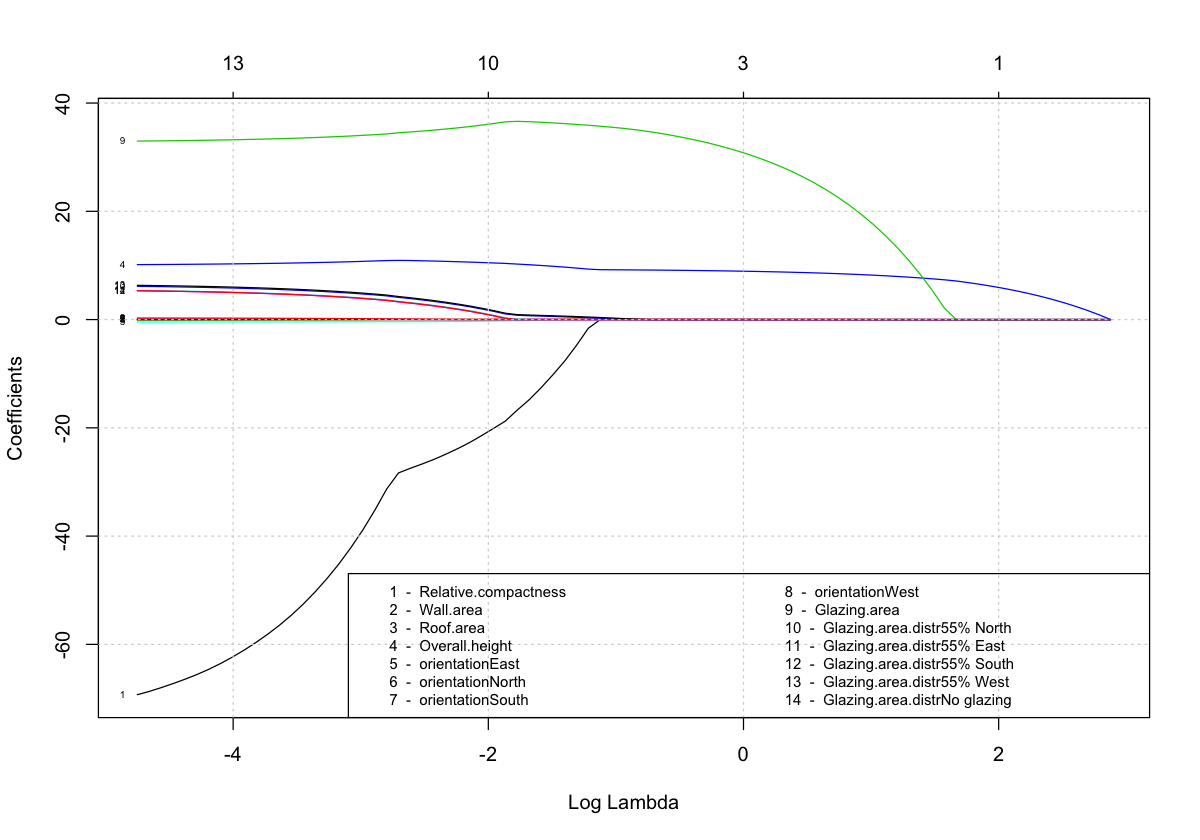

In [67]:
# avec toutes les variables, créer d'abord la matrice d'expériences 
# avec 'model.matrix' (penser à retirer l'intercept du modèle) 
x.mat.train <- model.matrix(Energy ~ . - 1, data = x_train_reg) #permet de gérer les variables catégorielles
reg.lasso <- glmnet(y = x_train_reg$Energy, x = x.mat.train)
options(repr.plot.width = 10, repr.plot.height = 7)
plot(reg.lasso, xvar = "lambda", label = TRUE)
grid()
legend("bottomright", 
       legend = paste(1:ncol(x.mat.train), " - ", colnames(x.mat.train)), ncol=2, cex=0.75)

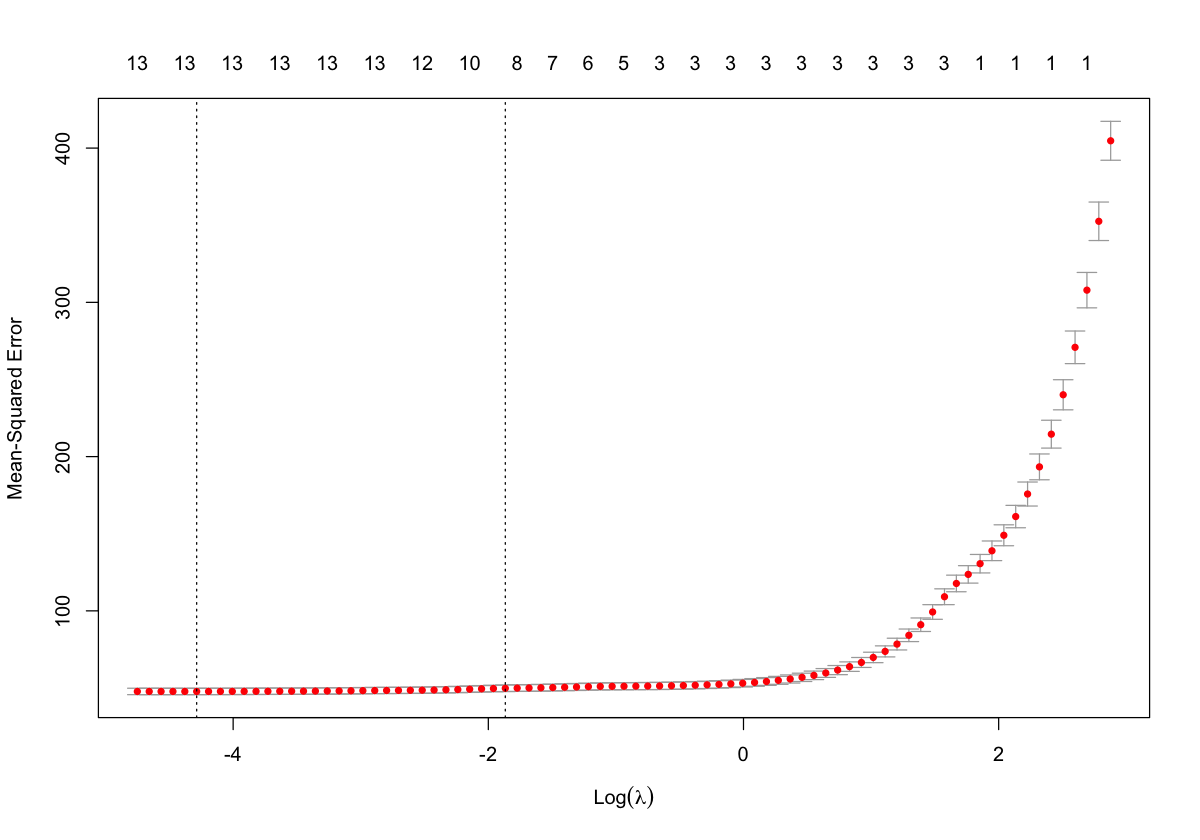

In [68]:
# choix du paramètre de régularisation par validation croisée
reg.lasso.cv <- cv.glmnet(y = x_train_reg$Energy, x = x.mat.train)
plot(reg.lasso.cv)

In [69]:
#Coefficients du modèle retenus par la pénalisation LASSO
coef(reg.lasso.cv, s = "lambda.1se")

15 x 1 sparse Matrix of class "dgCMatrix"
                                        1
(Intercept)                  -23.41330558
Relative.compactness         -18.76208960
Wall.area                      0.06631093
Roof.area                      .         
Overall.height                10.37700270
orientationEast               -0.23896694
orientationNorth               .         
orientationSouth               .         
orientationWest                .         
Glazing.area                  36.52819666
Glazing.area.distr55% North    1.04715736
Glazing.area.distr55% East     0.34808613
Glazing.area.distr55% South    0.21113542
Glazing.area.distr55% West     1.17939843
Glazing.area.distrNo glazing   0.24342460

**Résultats :**

In [70]:
x.mat.test <- model.matrix(Energy ~ . - 1, data = x_test_reg)
fit.lasso <- predict(reg.lasso.cv, s = "lambda.1se", newx = x.mat.test) #valeur predite sur le jeu de train
#res.lasso <- datappr$O3obs - fit.lasso

In [71]:
Tab_score_reg <- Compute_Error(predict.naivelm,quali = FALSE, name_model = "Lasso penalisation");Tab_score_reg

Table de contingende de Lasso penalisation : 
        observations
pred.reg  A  B  C  D  E  F  G
       A 34  6  4  0  0  0  0
       B  7  9  6  1  0  0  0
       C  4 10 14  0  0  0  0
       D  0  1  1  6  1  0  0
       E  0  0  1 11 20 11  1
       F  0  0  0  5  8 16  9
       G  0  0  0  0  0  0  6


Modele             Score1   Score2     RMSE    
1 Naive Regression   0.546875 0.07142857 7.052653
2 Lasso penalisation 0.546875 0.07142857 7.052653

On arrive pas à rendre le modèle aussi bon que le modèle complet avec de la pénalisation LASSO (prise à 1 SE) on va donc étudier une autre méthode de pénalisation.

#### ii) Akaike Information Criterion (AIC) :  

**Mise en place du modèle :**

In [72]:
#Test sur le modèle sans les intéractions
reg.lm <- glm(Energy~ ., data=x_train_reg)
reg.lm.step <- step(reg.lm, direction = "backward")
anova(reg.lm.step, test='F')
predict.lmstep <- predict(reg.lm.step, newdata=x_test_reg)
Tab_score_reg <- Compute_Error(predict.lmstep,quali = FALSE, name_model = "AIC penalisation");Tab_score_reg

Start:  AIC=3865.68
Energy ~ Relative.compactness + Wall.area + Roof.area + Overall.height + 
    orientation + Glazing.area + Glazing.area.distr

                       Df Deviance    AIC
- orientation           3    26349 3860.7
- Wall.area             1    26302 3863.7
<none>                       26302 3865.7
- Roof.area             1    26575 3869.6
- Relative.compactness  1    27064 3880.1
- Glazing.area.distr    5    27465 3880.6
- Overall.height        1    33814 4008.4
- Glazing.area          1    34643 4022.3

Step:  AIC=3860.72
Energy ~ Relative.compactness + Wall.area + Roof.area + Overall.height + 
    Glazing.area + Glazing.area.distr

                       Df Deviance    AIC
- Wall.area             1    26350 3858.7
<none>                       26349 3860.7
- Roof.area             1    26617 3864.5
- Relative.compactness  1    27111 3875.1
- Glazing.area.distr    5    27507 3875.5
- Overall.height        1    33915 4004.1
- Glazing.area          1    34725 4017.7

Step:

Df Deviance  Resid. Df Resid. Dev F          
NULL                 NA        NA 575       233397.06           NA
Relative.compactness  1 87754.364 574       145642.70  1884.988916
Roof.area             1 94202.957 573        51439.74  2023.506542
Overall.height        1  9665.730 572        41774.01   207.622654
Glazing.area          1 14263.835 571        27510.18   306.391274
Glazing.area.distr    5  1160.436 566        26349.74     4.985299
                     Pr(>F)       
NULL                            NA
Relative.compactness 2.789817e-182
Roof.area            4.845271e-189
Overall.height        2.524642e-40
Glazing.area          3.774894e-55
Glazing.area.distr    1.772799e-04

Table de contingende de AIC penalisation : 
        observations
pred.reg  A  B  C  D  E  F  G
       A 33  5  5  0  0  0  0
       B  8 10  5  1  0  0  0
       C  4 10 14  0  0  0  0
       D  0  1  1  6  1  0  0
       E  0  0  1 11 21 11  1
       F  0  0  0  5  7 16  9
       G  0  0  0  0  0  0  6


Modele             Score1    Score2     RMSE    
1 Naive Regression   0.5468750 0.07142857 7.052653
2 Lasso penalisation 0.5468750 0.07142857 7.052653
3 AIC penalisation   0.5520833 0.07142857 7.066029

Pour appliquer la méthode qui va minimiser le critère AIC (penalise les modèles avec beaucoup de variables) on part d'un modèle avec les intéractions du second ordre (modèle quadratique) puis on réalise la pénalisation au sens d'Akaike de façon descendante et on étudie les résultats.

In [73]:
reg.glm <- glm(Energy~ .^2, data=x_train_reg)
# du critère d'Akaïke par méthode descendante
reg.glm.step <- step(reg.glm, direction = "backward")

Start:  AIC=3765.63
Energy ~ (Relative.compactness + Wall.area + Roof.area + Overall.height + 
    orientation + Glazing.area + Glazing.area.distr)^2

                                          Df Deviance    AIC
- orientation:Glazing.area.distr          15    18170 3752.6
- Roof.area:Glazing.area.distr             5    17677 3756.8
- Relative.compactness:Glazing.area.distr  5    17683 3757.0
- Wall.area:Glazing.area.distr             5    17691 3757.2
- Overall.height:Glazing.area.distr        5    17695 3757.4
- Glazing.area:Glazing.area.distr          5    17793 3760.5
- Relative.compactness:orientation         3    17707 3761.8
- Wall.area:orientation                    3    17715 3762.0
- Roof.area:orientation                    3    17751 3763.2
- orientation:Glazing.area                 3    17762 3763.5
- Wall.area:Glazing.area                   1    17641 3763.6
- Overall.height:Glazing.area              1    17642 3763.7
- Relative.compactness:Glazing.area        1    17643 37

In [74]:
#On réalise un test de fischer sur le résultat pour confirmer que toutes les variables retenues sont bien significatives
anova(reg.glm.step, test='F')

Df Deviance    Resid. Df Resid. Dev
NULL                                NA          NA 575       233397.06 
Relative.compactness                 1 87754.36370 574       145642.70 
Wall.area                            1 77073.82466 573        68568.87 
Roof.area                            1 19656.39765 572        48912.48 
Overall.height                       1  7175.69269 571        41736.78 
orientation                          3    86.14291 568        41650.64 
Glazing.area                         1 14185.55474 567        27465.09 
Glazing.area.distr                   5  1163.37260 562        26301.71 
Relative.compactness:Roof.area       1   272.55188 561        26029.16 
Relative.compactness:Overall.height  1  1834.79199 560        24194.37 
Relative.compactness:Glazing.area    1  1596.73934 559        22597.63 
Wall.area:Roof.area                  1   124.48240 558        22473.15 
Wall.area:Overall.height             1  2164.47329 557        20308.67 
Wall.area:Glazing.area               1   284.92555 556        20023.75 
Roof.area:Overall.height             1   527.42874 555        19496.32 
Overall.height:orientation           3   227.43062 552        19268.89 
Overall.height:Glazing.area.distr    5   409.16749 547        18859.72 
                                    F            Pr(>F)       
NULL                                          NA            NA
Relative.compactness                2545.1932168 6.705996e-208
Wall.area                           2235.4190431 2.344532e-195
Roof.area                            570.1064637  7.306877e-87
Overall.height                       208.1209823  3.255022e-40
orientation                            0.8328184  4.761877e-01
Glazing.area                         411.4322774  1.252611e-68
Glazing.area.distr                     6.7484007  4.064832e-06
Relative.compactness:Roof.area         7.9049879  5.106727e-03
Relative.compactness:Overall.height   53.2155888  1.055830e-12
Relative.compactness:Glazing.area     46.3112029  2.657135e-11
Wall.area:Roof.area                    3.6104388  5.794353e-02
Wall.area:Overall.height              62.7775363  1.302993e-14
Wall.area:Glazing.area                 8.2638693  4.201566e-03
Roof.area:Overall.height              15.2973368  1.034000e-04
Overall.height:orientation             2.1987696  8.721708e-02
Overall.height:Glazing.area.distr      2.3734667  3.804105e-02

**Résultats :**

In [75]:
pred.step.glm <- predict(reg.glm.step, newdata=x_test_reg)

In [76]:
Tab_score_reg <- Compute_Error(pred.step.glm,quali = FALSE, name_model = "AIC penalisation quadra");Tab_score_reg

Table de contingende de AIC penalisation quadra : 
        observations
pred.reg  A  B  C  D  E  F  G
       A 35  7  5  0  0  0  0
       B  7 16 13  1  0  0  0
       C  3  2  6  1  0  0  0
       D  0  1  1  8  2  0  0
       E  0  0  1  8 16 13  0
       F  0  0  0  5 11 13  4
       G  0  0  0  0  0  1 12


Modele                  Score1    Score2     RMSE    
1 Naive Regression        0.5468750 0.07142857 7.052653
2 Lasso penalisation      0.5468750 0.07142857 7.052653
3 AIC penalisation        0.5520833 0.07142857 7.066029
4 AIC penalisation quadra 0.5520833 0.08928571 6.533080

### c) Optimal Tree :  

**Mise en place du modèle :**

In [77]:
options(repr.plot.width = 15, repr.plot.height = 10)
tree.reg=rpart(Energy~.,data=x_train_reg,control=rpart.control(cp=0.001))

cp opti : 0.001018333

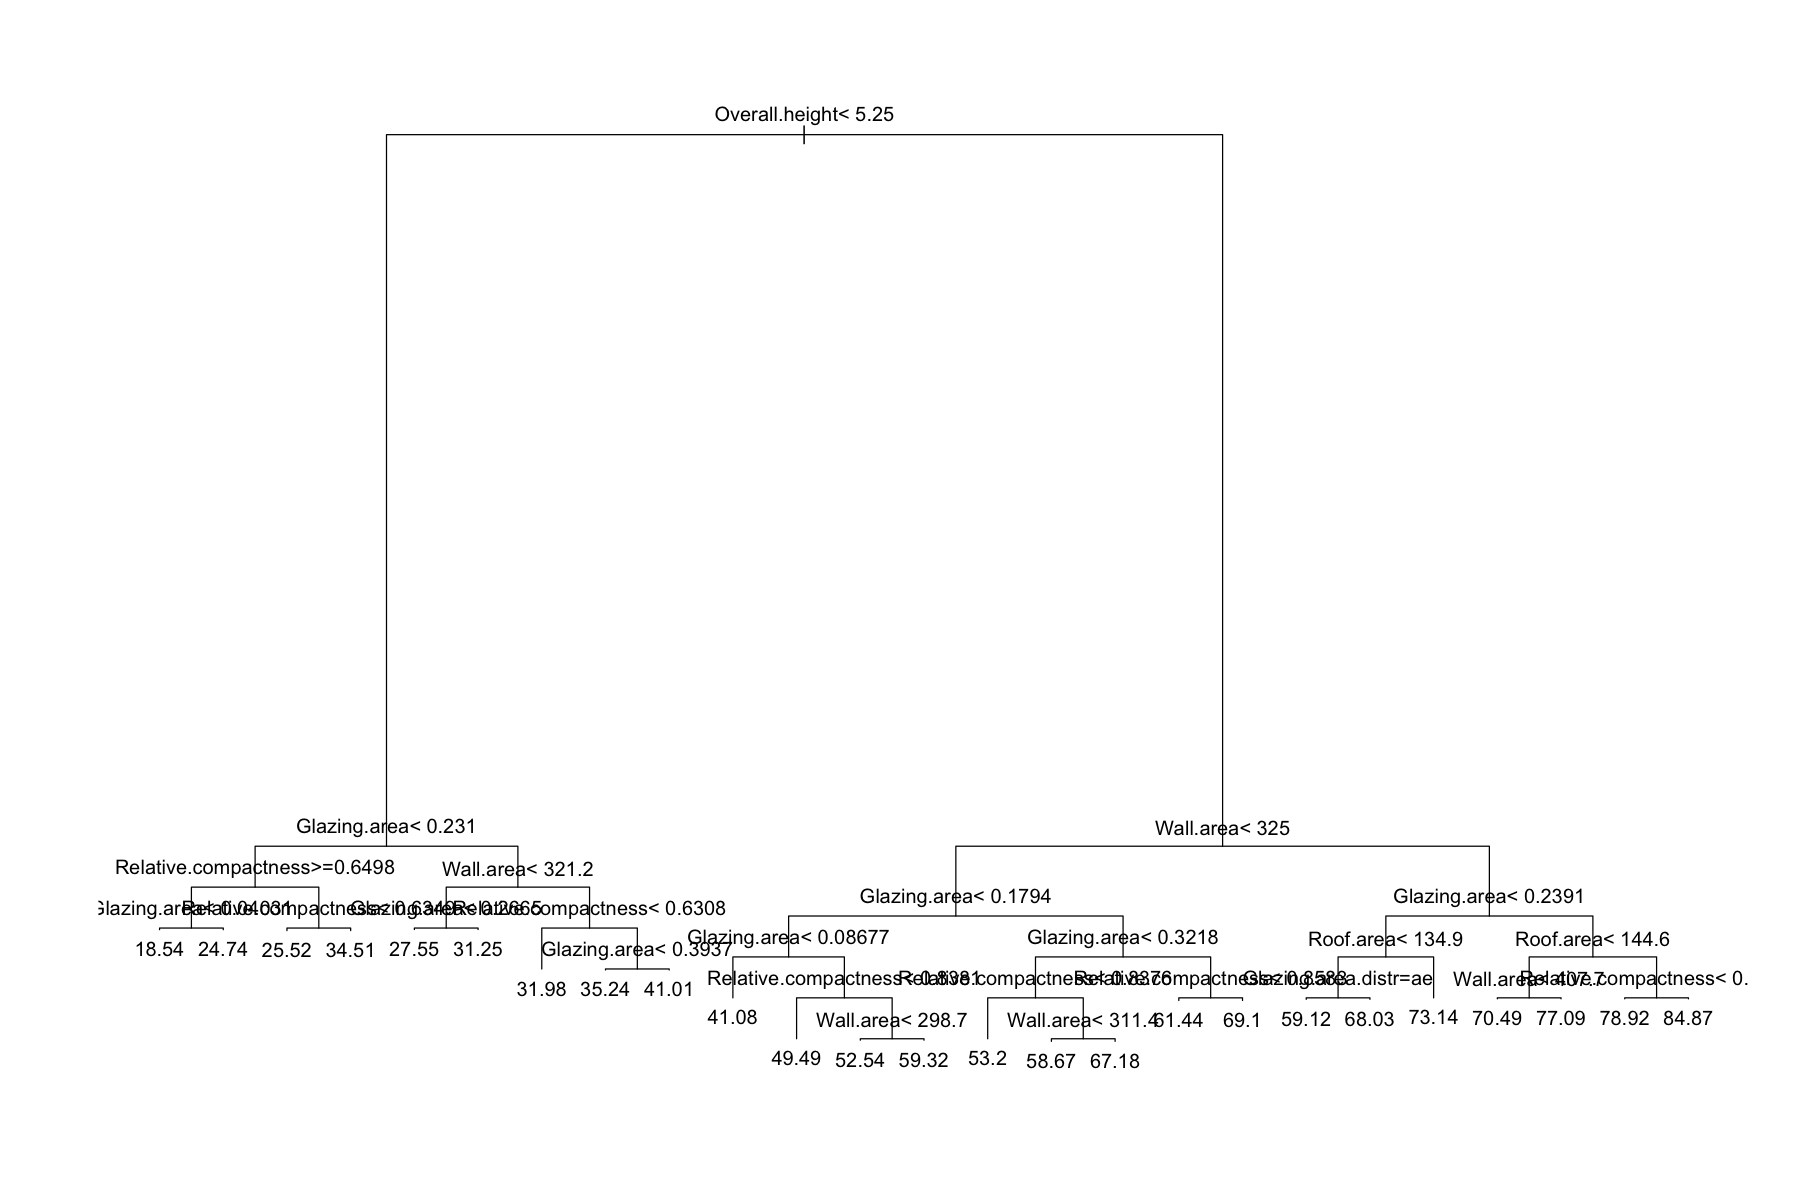

In [78]:
xmat=xpred.rpart(tree.reg, xval = 10)
#levels(datappr[,"Survived"]) <- c(1,2)
xerr <- (xmat-as.numeric(x_train_reg[, "Energy"]))^2
CVerr=apply(xerr,2,sum)
#CVerr  #    CP           erreur
cp_opti = as.numeric(attributes(which.min(CVerr))$names); 

cat('cp opti :', cp_opti)

tree.opti.reg=rpart(Energy~.,data=x_train_reg,control=rpart.control(cp=cp_opti))
options(repr.plot.width = 15, repr.plot.height = 10)
plot(tree.opti.reg)
text(tree.opti.reg)

**Résultats :**

In [79]:
predict.tree <- predict(tree.opti.reg, newdata = x_test_reg)
Tab_score_reg <- Compute_Error(predict.tree,quali = FALSE, name_model = "Tree Opti");Tab_score_reg


Table de contingende de Tree Opti : 
        observations
pred.reg  A  B  C  D  E  F  G
       A 33  5  2  0  0  0  0
       B 12 15 11  0  0  0  0
       C  0  6 12  3  1  0  0
       D  0  0  1 12  2  0  0
       E  0  0  0  8 19  7  0
       F  0  0  0  0  6 19  4
       G  0  0  0  0  1  1 12


Modele                  Score1    Score2     RMSE    
1 Naive Regression        0.5468750 0.07142857 7.052653
2 Lasso penalisation      0.5468750 0.07142857 7.052653
3 AIC penalisation        0.5520833 0.07142857 7.066029
4 AIC penalisation quadra 0.5520833 0.08928571 6.533080
5 Tree Opti               0.6354167 0.33928571 5.609057

###  d) Random Forest :  

**Mise en place du modèle :**

In [80]:
set.seed(69)
rf <- randomForest(Energy ~ ., data = x_train_reg, 
                       xtest = x_test_reg[,-c(8)], ytest = x_test_reg$Energy,
                       ntree = 500,do.trace = 50, importance = TRUE)



     |      Out-of-bag   |       Test set    |
Tree |      MSE  %Var(y) |      MSE  %Var(y) |
  50 |    24.27     5.99 |    22.43     6.24 |
 100 |    23.41     5.78 |    21.67     6.03 |
 150 |    23.03     5.68 |    21.33     5.93 |
 200 |    23.02     5.68 |    21.24     5.91 |
 250 |    22.88     5.65 |    21.25     5.91 |
 300 |    22.74     5.61 |    21.31     5.93 |
 350 |    22.61     5.58 |    21.16     5.88 |
 400 |    22.63     5.58 |    21.26     5.91 |
 450 |    22.64     5.59 |     21.2     5.90 |
 500 |    22.61     5.58 |     21.3     5.92 |


**Résultats :**

In [81]:
pred.rf.reg <- rf$test$predicted
Tab_score_reg <- Compute_Error(pred.rf.reg,quali = FALSE, name_model = "Random Forest");Tab_score_reg

Table de contingende de Random Forest : 
        observations
pred.reg  A  B  C  D  E  F  G
       A 34  7  1  0  0  0  0
       B 11 15 12  0  0  0  0
       C  0  4 12  2  0  0  0
       D  0  0  1 14  0  0  0
       E  0  0  0  7 26 11  0
       F  0  0  0  0  3 15  1
       G  0  0  0  0  0  1 15


Modele                  Score1    Score2     RMSE    
1 Naive Regression        0.5468750 0.07142857 7.052653
2 Lasso penalisation      0.5468750 0.07142857 7.052653
3 AIC penalisation        0.5520833 0.07142857 7.066029
4 AIC penalisation quadra 0.5520833 0.08928571 6.533080
5 Tree Opti               0.6354167 0.33928571 5.609057
6 Random Forest           0.6822917 0.44642857 4.615168

**Mise en place du modèle optimisé :**

In [82]:
set.seed(69)
cvControl <- trainControl(method = "cv", number = 10)
mtryTrials <- train(x_train_reg, x_train_reg$Energy, method = "rf", tuneLength = 7,
               trControl = cvControl, trace = FALSE)
mtryTrials

Random Forest 

576 samples
  8 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 518, 518, 518, 519, 519, 517, ... 
Resampling results across tuning parameters:

  mtry  RMSE       Rsquared   MAE      
  2     2.0809915  0.9901562  1.4529940
  3     1.4194589  0.9953307  0.9303250
  4     1.0036969  0.9976258  0.5952509
  5     0.7031099  0.9988102  0.3851753
  6     0.4746846  0.9994410  0.2445069
  7     0.3364666  0.9997071  0.1648257
  8     0.2628082  0.9998099  0.1183933

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 8.

In [83]:
set.seed(69)
rf.opti <- randomForest(Energy ~ ., data = x_train_reg, 
                       xtest = x_test_reg[,-c(8)], ytest = x_test_reg$Energy,
                       ntree = 500,mtry=7,do.trace = 50, importance = TRUE)

     |      Out-of-bag   |       Test set    |
Tree |      MSE  %Var(y) |      MSE  %Var(y) |
  50 |    22.43     5.54 |    22.92     6.37 |
 100 |    22.59     5.58 |    22.83     6.35 |
 150 |    22.48     5.55 |    22.61     6.29 |
 200 |    22.44     5.54 |    22.23     6.18 |
 250 |    22.51     5.55 |    22.01     6.12 |
 300 |    22.44     5.54 |    22.05     6.13 |
 350 |    22.37     5.52 |    22.08     6.14 |
 400 |     22.3     5.50 |     22.1     6.15 |
 450 |    22.36     5.52 |    22.19     6.17 |
 500 |    22.37     5.52 |     22.2     6.17 |


**Résultats :**

In [84]:
pred.rfOpti.reg <- rf.opti$test$predicted
Tab_score_reg <- Compute_Error(pred.rfOpti.reg,quali = FALSE, name_model = "Random Forest Opti");Tab_score_reg

Table de contingende de Random Forest Opti : 
        observations
pred.reg  A  B  C  D  E  F  G
       A 35  7  1  0  0  0  0
       B 10 12 10  0  0  0  0
       C  0  7 14  2  0  0  0
       D  0  0  1 13  2  0  0
       E  0  0  0  8 21  7  0
       F  0  0  0  0  5 18  1
       G  0  0  0  0  1  2 15


Modele                  Score1    Score2     RMSE    
1 Naive Regression        0.5468750 0.07142857 7.052653
2 Lasso penalisation      0.5468750 0.07142857 7.052653
3 AIC penalisation        0.5520833 0.07142857 7.066029
4 AIC penalisation quadra 0.5520833 0.08928571 6.533080
5 Tree Opti               0.6354167 0.33928571 5.609057
6 Random Forest           0.6822917 0.44642857 4.615168
7 Random Forest Opti      0.6666667 0.41071429 4.711930

### e) Boosting :  

In [85]:
#Ajuster les paramètres !!!!!!!

#Faire un banc de test comme en signal : variation des paramètres et
#plot de graphes de l'erreur selon la valeur des paramètres
#Sans doute long à run mais nécessaire pour boosting et SVM .....

**Mise en place du modèle :**

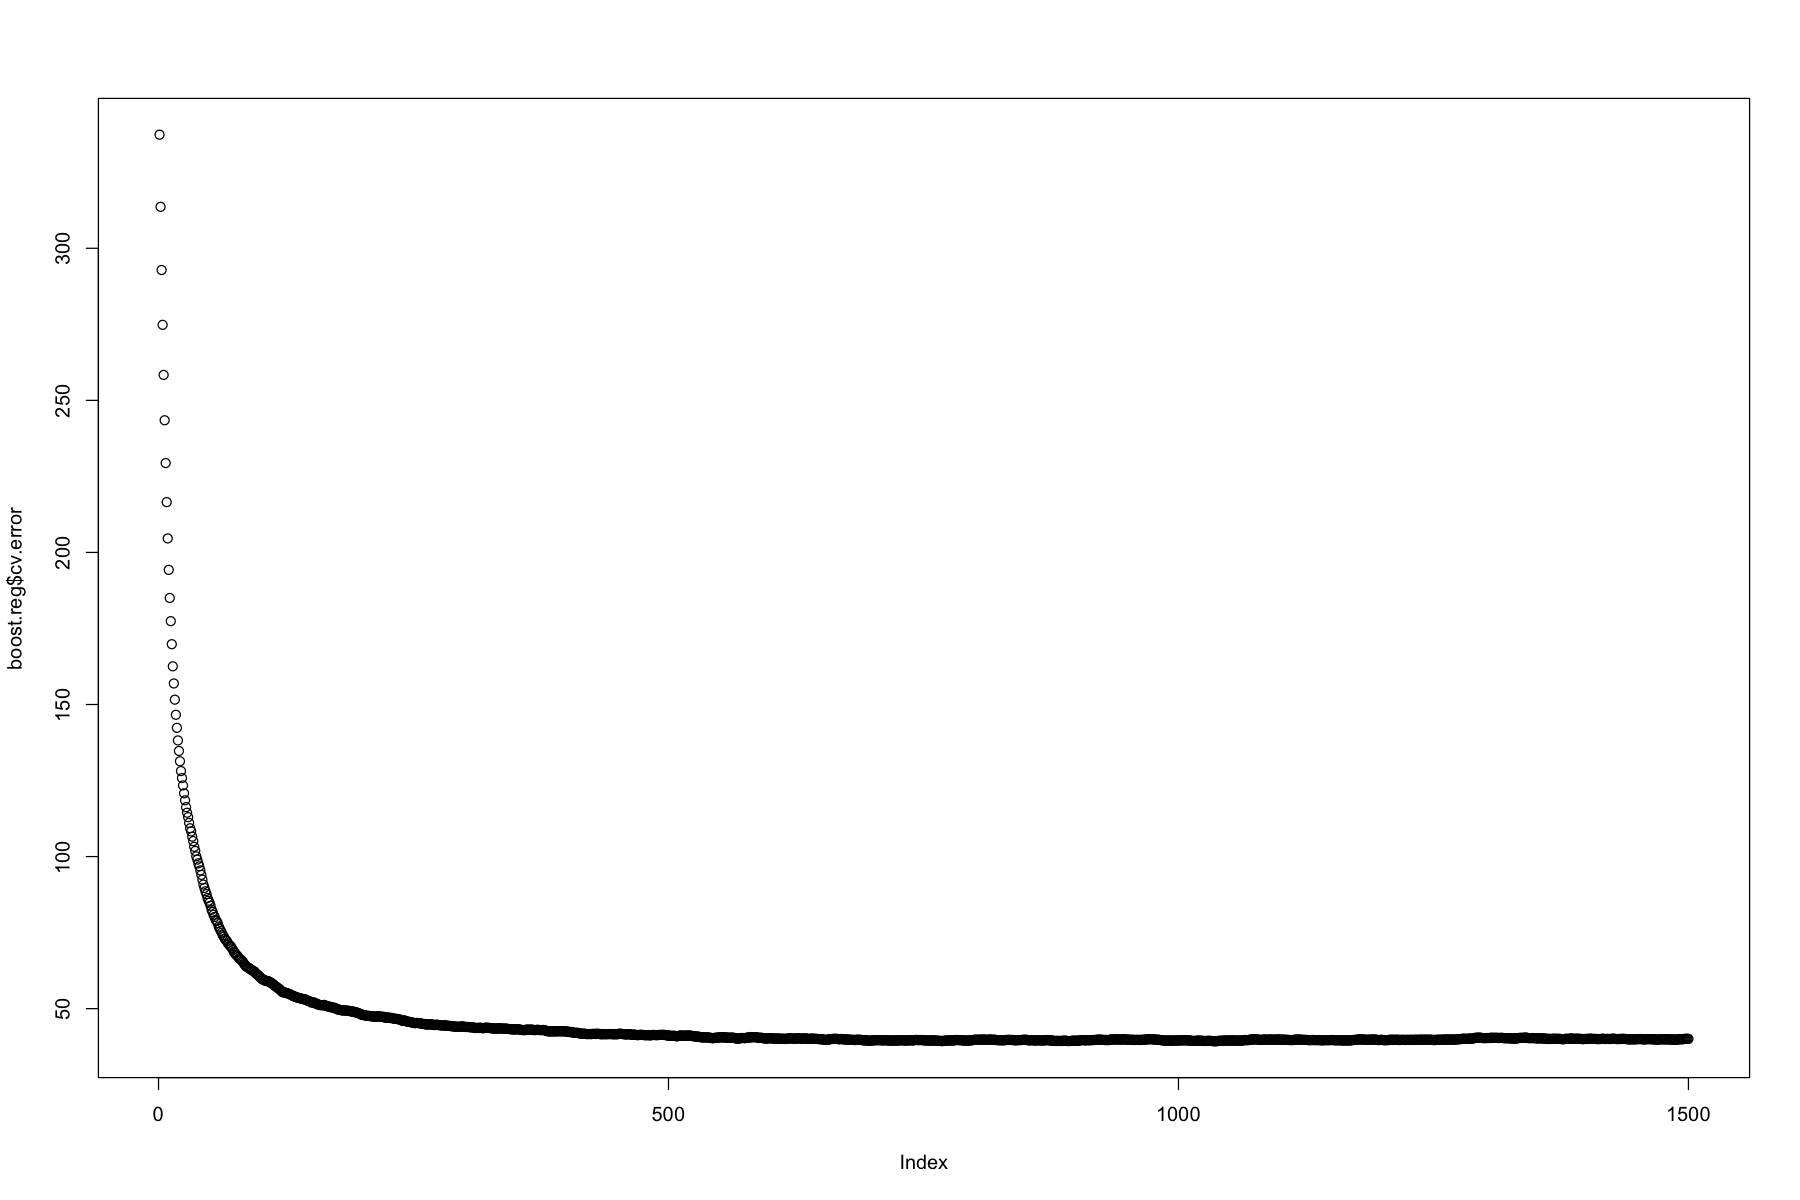

In [86]:
boost.reg=gbm(Energy~., data=x_test_reg,distribution="gaussian",n.trees=1500, cv.folds=10,
        n.minobsinnode = 5,shrinkage=0.05,verbose=FALSE)
# fixer verbose à FALSE pour éviter trop de sorties
plot(boost.reg$cv.error)

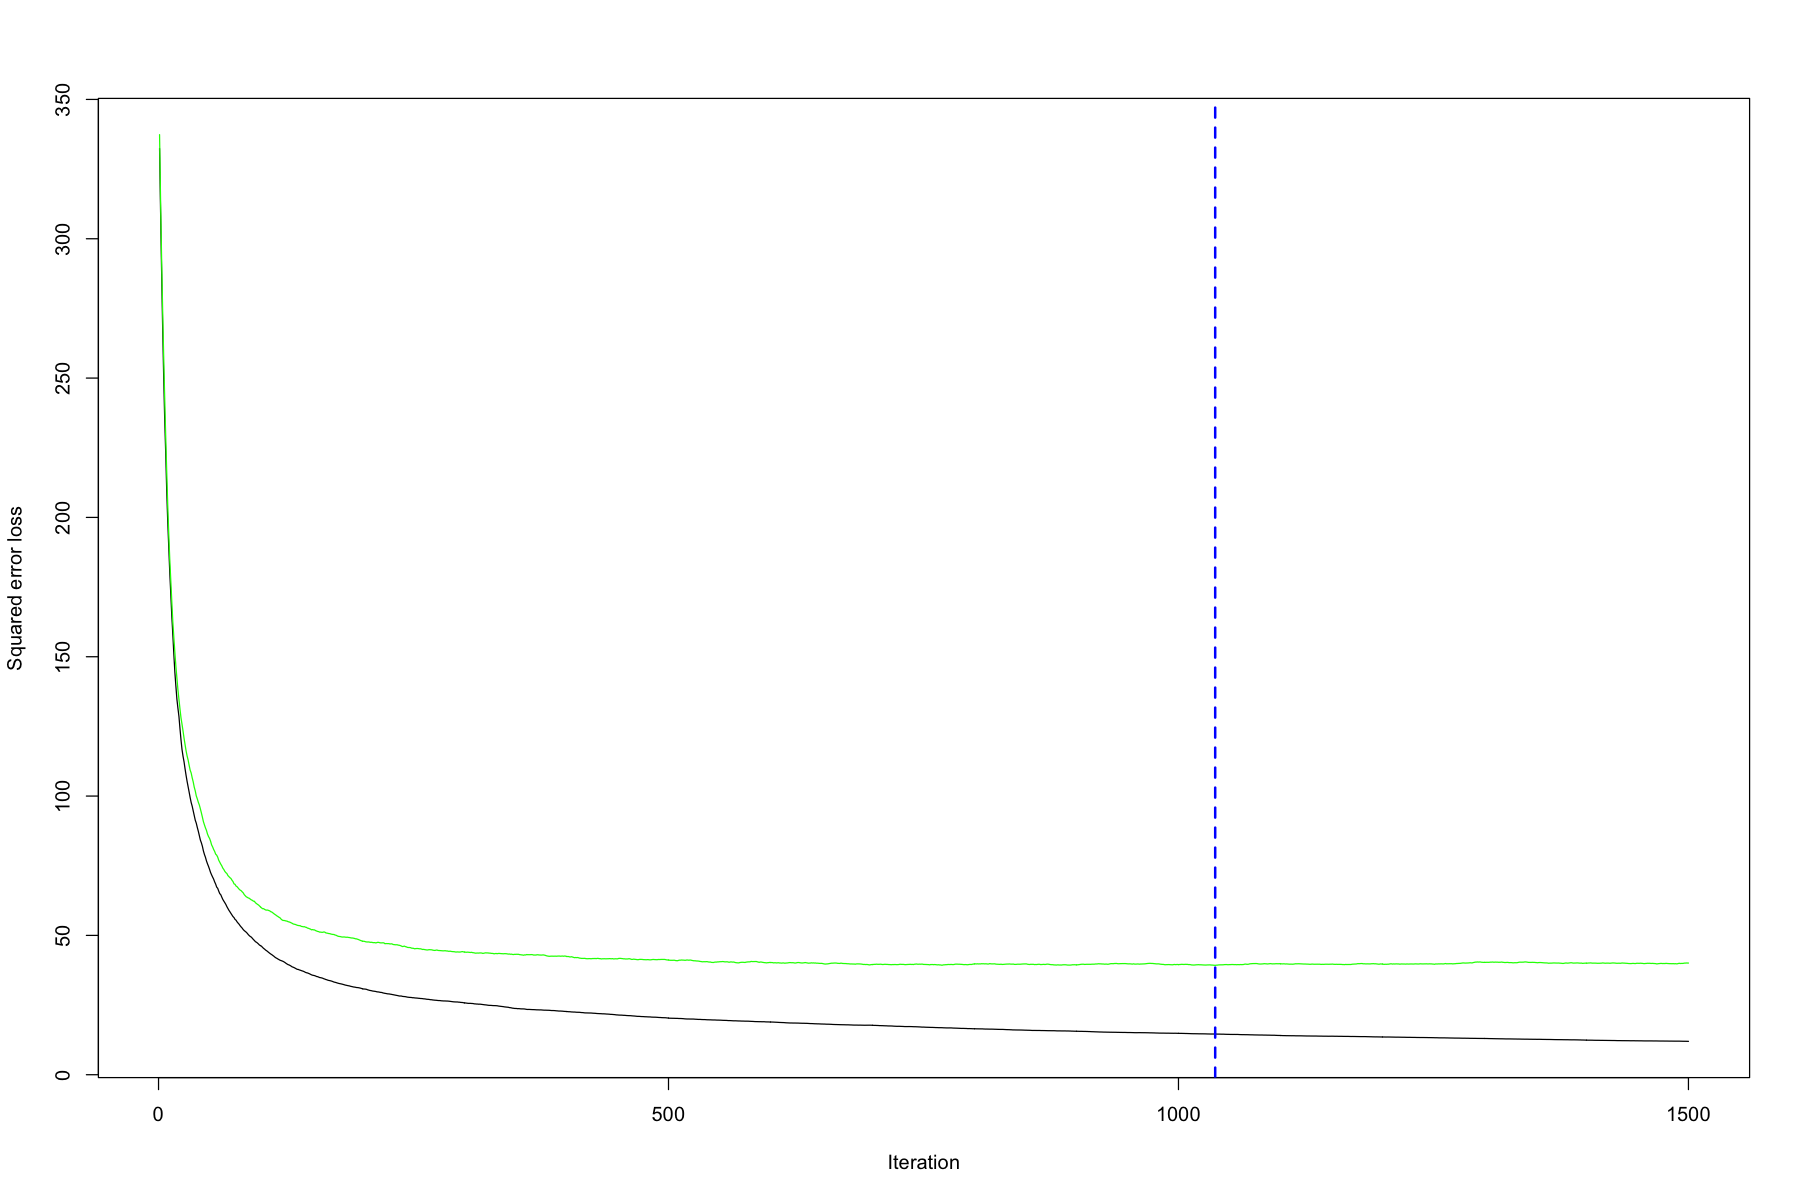

In [87]:
# nombre optimal d'itérations par valiation croisée
best.iter=gbm.perf(boost.reg,method="cv")

#noir : apprentissage
#vert : validation croisée

In [88]:
best.iter

[1] 1036

### Selection des bons paramètres par un banc de test :

In [89]:
#faire varier : n_tree, shrinkage=learning_rate, interaction_depth=profondeur des arbres

In [90]:
#enregistrer les results dans un tableau puis plot

In [107]:
X_TRAIN_REG =  dplyr::select(x_train, Relative.compactness, Wall.area,Roof.area,Overall.height,orientation, Glazing.area,Glazing.area.distr)
Y_TRAIN_REG =  x_train$Energy

In [169]:
library(caret)

cvvv = trainControl(method = "cv", number = 10, search='random')
gbmFit = train(X_TRAIN_REG, Y_TRAIN_REG, method='gbm', tuneLength=4, trControl=cvvv)

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1      404.6152             nan     0.0018    1.2957
     2      403.3576             nan     0.0018    1.3019
     3      402.0409             nan     0.0018    1.3024
     4      400.7293             nan     0.0018    1.2783
     5      399.3876             nan     0.0018    1.3684
     6      398.0582             nan     0.0018    1.2792
     7      396.7569             nan     0.0018    1.2493
     8      395.4350             nan     0.0018    1.2508
     9      394.1232             nan     0.0018    1.2271
    10      392.8149             nan     0.0018    1.2977
    20      380.1071             nan     0.0018    1.2123
    40      355.9681             nan     0.0018    1.1271
    60      333.4700             nan     0.0018    1.1203
    80      312.5918             nan     0.0018    0.9694
   100      293.1051             nan     0.0018    0.9635
   120      275.0954             nan     0.0018    0.8863
   140      25

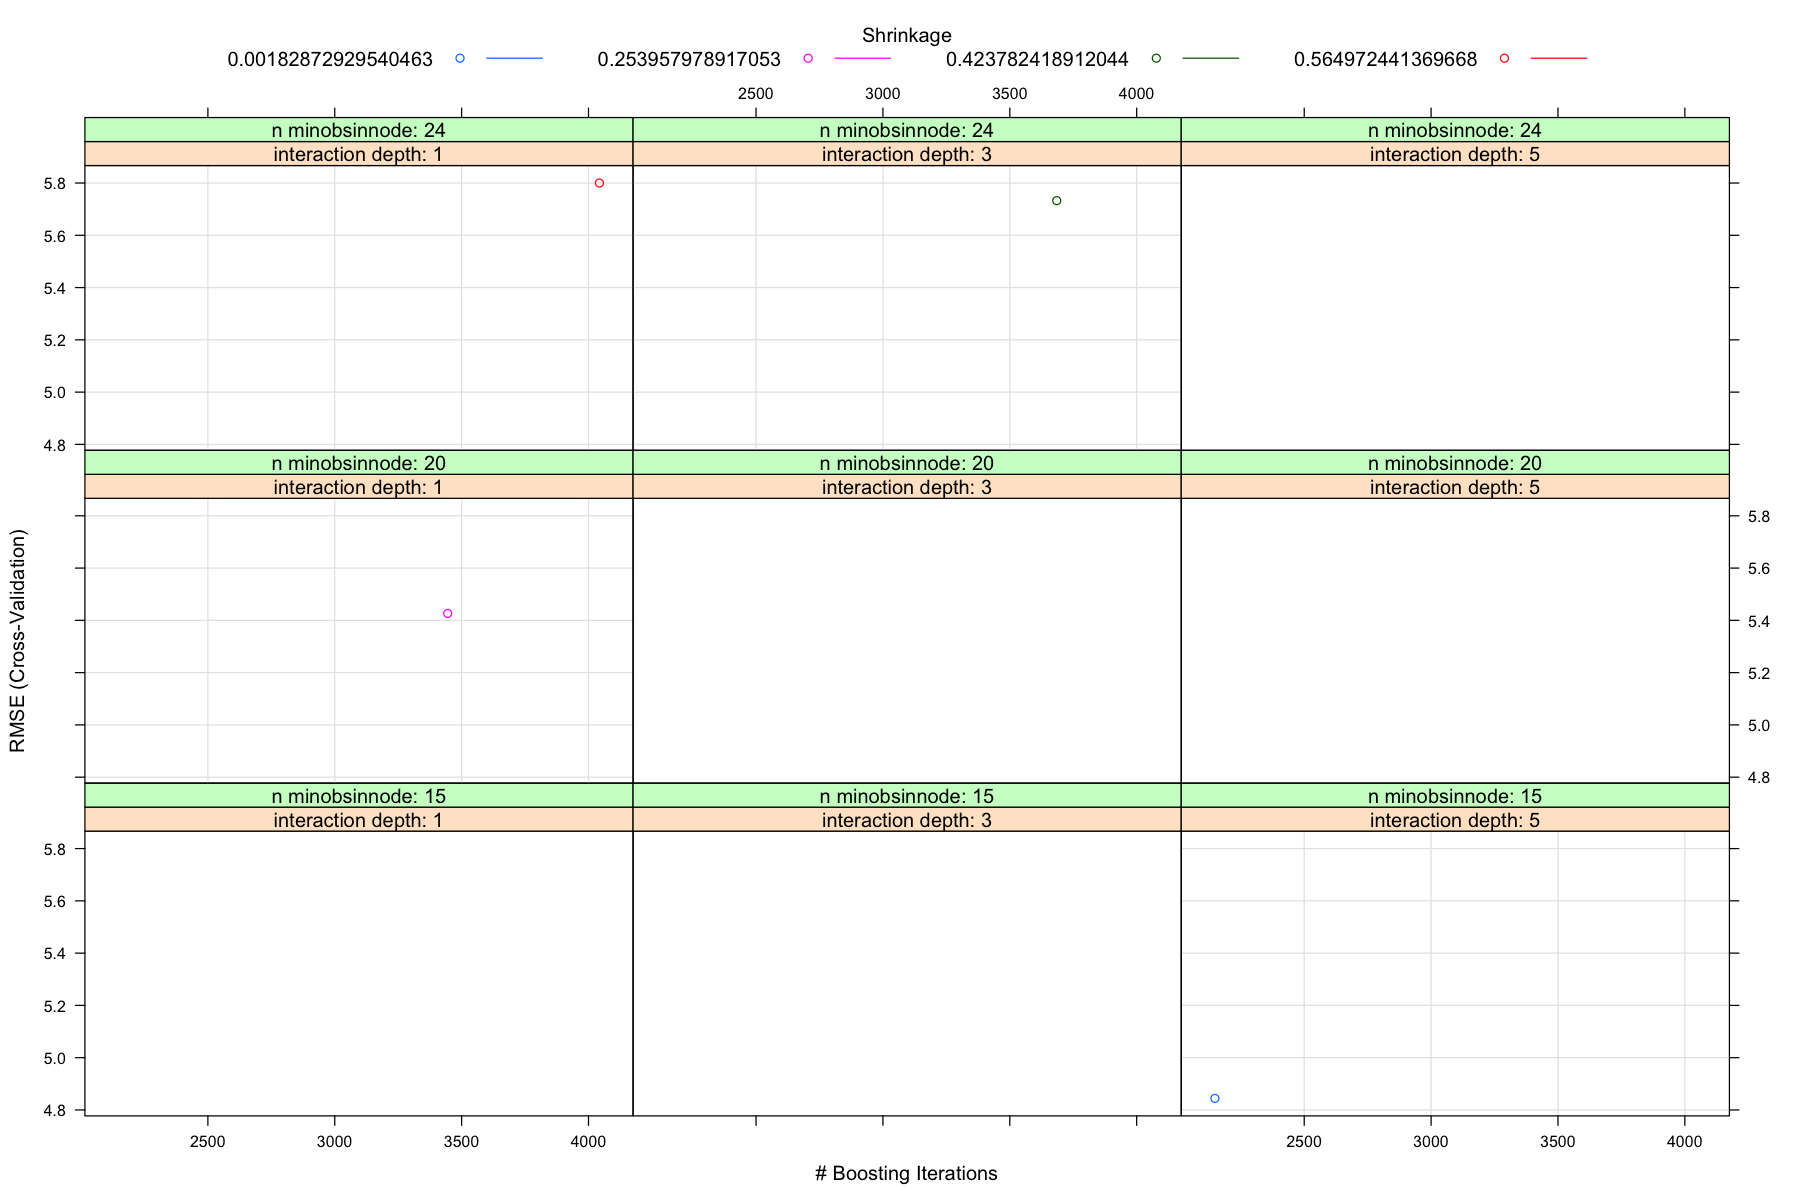

In [170]:
plot(gbmFit)

In [171]:
gbmFit

Stochastic Gradient Boosting 

576 samples
  7 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 516, 520, 520, 519, 520, 518, ... 
Resampling results across tuning parameters:

  shrinkage    interaction.depth  n.minobsinnode  n.trees  RMSE      Rsquared 
  0.001828729  5                  15              2148     4.844189  0.9444311
  0.253957979  1                  20              3445     5.426512  0.9286597
  0.423782419  3                  24              3685     5.732506  0.9216817
  0.564972441  1                  24              4043     5.799979  0.9186119
  MAE     
  3.806559
  4.283708
  4.510812
  4.641938

RMSE was used to select the optimal model using the smallest value.
The final values used for the model were n.trees = 2148, interaction.depth =
 5, shrinkage = 0.001828729 and n.minobsinnode = 15.

In [172]:
X_TEST_REG = dplyr::select(x_test, Relative.compactness, Wall.area,Roof.area,Overall.height,orientation, Glazing.area,Glazing.area.distr)

In [173]:
p = predict(list(gbm=gbmFit), newdata = X_TEST_REG)

In [174]:
Tab_score_reg <- Compute_Error(p$gbm, quali = FALSE, 
                               name_model = "GBM Opti");Tab_score_reg

Table de contingende de GBM Opti : 
        observations
pred.reg  A  B  C  D  E  F  G
       A 31  5  0  0  0  0  0
       B 14 16 14  0  0  0  0
       C  0  5 11  2  0  0  0
       D  0  0  1 12  5  0  0
       E  0  0  0  9 18  8  0
       F  0  0  0  0  6 18  4
       G  0  0  0  0  0  1 12


Modele                  Score1    Score2     RMSE    
1  Naive Regression        0.5468750 0.07142857 7.052653
2  Lasso penalisation      0.5468750 0.07142857 7.052653
3  AIC penalisation        0.5520833 0.07142857 7.066029
4  AIC penalisation quadra 0.5520833 0.08928571 6.533080
5  Tree Opti               0.6354167 0.33928571 5.609057
6  Random Forest           0.6822917 0.44642857 4.615168
7  Random Forest Opti      0.6666667 0.41071429 4.711930
8  Boosting Naive          0.7291667 0.51785714 3.822756
9  SVM cost                0.5625000 0.14285714 6.312165
10 Best SVM                0.5937500 0.22321429 5.896491
11 GBM Opti                0.6406250 0.34821429 4.902960
12 GBM Opti                0.6458333 0.33928571 4.881529
13 GBM Opti                0.6197917 0.33035714 4.820700
14 GBM Opti                0.6562500 0.39285714 4.735512
15 GBM Opti                0.6458333 0.36607143 4.821096
16 GBM Opti                0.6510417 0.34821429 4.983560
17 GBM Opti                0.6145833 0.33928571 4.967052

**Résultats :**

In [91]:
pred.boosting.reg=predict(boost.reg,newdata=x_test_reg,n.trees=best.iter)

Tab_score_reg <- Compute_Error(pred.boosting.reg,quali = FALSE, name_model = "Boosting Naive");Tab_score_reg



Table de contingende de Boosting Naive : 
        observations
pred.reg  A  B  C  D  E  F  G
       A 34  5  1  0  0  0  0
       B 10 15  7  0  0  0  0
       C  1  6 17  1  0  0  0
       D  0  0  1 15  0  0  0
       E  0  0  0  7 25  7  0
       F  0  0  0  0  4 19  1
       G  0  0  0  0  0  1 15


Modele                  Score1    Score2     RMSE    
1 Naive Regression        0.5468750 0.07142857 7.052653
2 Lasso penalisation      0.5468750 0.07142857 7.052653
3 AIC penalisation        0.5520833 0.07142857 7.066029
4 AIC penalisation quadra 0.5520833 0.08928571 6.533080
5 Tree Opti               0.6354167 0.33928571 5.609057
6 Random Forest           0.6822917 0.44642857 4.615168
7 Random Forest Opti      0.6666667 0.41071429 4.711930
8 Boosting Naive          0.7291667 0.51785714 3.822756

### f) SVM : 

**Mise en place du modèle :**

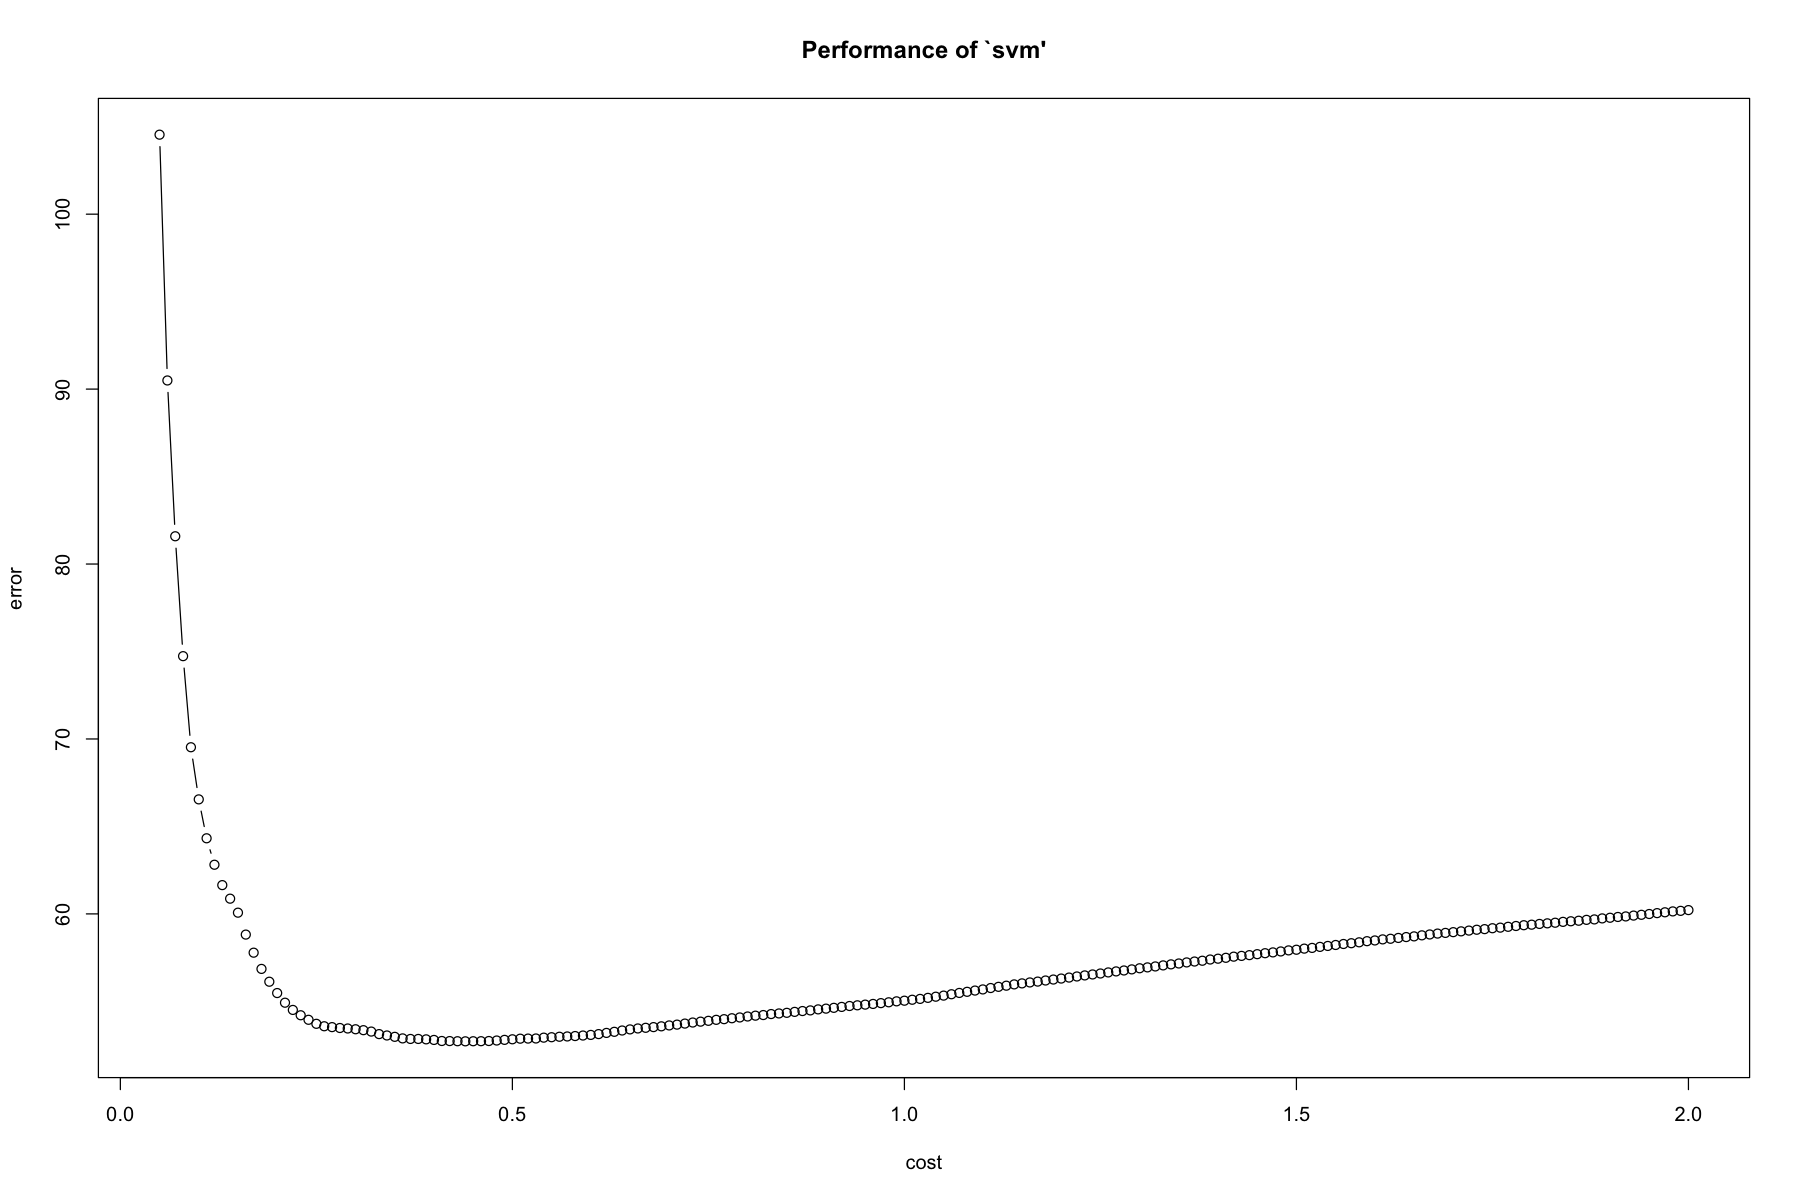

In [92]:
banc_test = tune.svm(Energy~.,data=x_test_reg,cost=seq(0.05,2,0.01))
plot(banc_test)

In [93]:
banc_test 
cost_opti = banc_test$best.parameters; cost_opti


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 cost
 0.44

- best performance: 52.71504 


cost
40 0.44

In [94]:
svm.reg=svm(Energy~.,data=x_test_reg,cost=cost_opti)
# calcul et graphe des résidus
fit.svmr=predict(svm.reg,data=x_test_reg)
Tab_score_reg <- Compute_Error(fit.svmr,quali = FALSE, name_model = "SVM cost");Tab_score_reg


Table de contingende de SVM cost : 
        observations
pred.reg  A  B  C  D  E  F  G
       A 30  4  2  0  0  0  0
       B 12 17 11  1  0  0  0
       C  3  4 10  0  0  0  0
       D  0  1  2 10  1  0  0
       E  0  0  1 10 21 12  2
       F  0  0  0  2  7 14  8
       G  0  0  0  0  0  1  6


Modele                  Score1    Score2     RMSE    
1 Naive Regression        0.5468750 0.07142857 7.052653
2 Lasso penalisation      0.5468750 0.07142857 7.052653
3 AIC penalisation        0.5520833 0.07142857 7.066029
4 AIC penalisation quadra 0.5520833 0.08928571 6.533080
5 Tree Opti               0.6354167 0.33928571 5.609057
6 Random Forest           0.6822917 0.44642857 4.615168
7 Random Forest Opti      0.6666667 0.41071429 4.711930
8 Boosting Naive          0.7291667 0.51785714 3.822756
9 SVM cost                0.5625000 0.14285714 6.312165

**Résultats :**

In [95]:
meilleur <- best.svm(Energy~.,data=x_test_reg)
Tab_score_reg <- Compute_Error(meilleur$fitted,quali = FALSE, name_model = "Best SVM");Tab_score_reg


Table de contingende de Best SVM : 
        observations
pred.reg  A  B  C  D  E  F  G
       A 29  3  1  0  0  0  0
       B 14 19 10  1  0  0  0
       C  2  3 13  0  0  0  0
       D  0  1  1  8  1  0  0
       E  0  0  1 12 22 10  1
       F  0  0  0  2  6 16  8
       G  0  0  0  0  0  1  7


Modele                  Score1    Score2     RMSE    
1  Naive Regression        0.5468750 0.07142857 7.052653
2  Lasso penalisation      0.5468750 0.07142857 7.052653
3  AIC penalisation        0.5520833 0.07142857 7.066029
4  AIC penalisation quadra 0.5520833 0.08928571 6.533080
5  Tree Opti               0.6354167 0.33928571 5.609057
6  Random Forest           0.6822917 0.44642857 4.615168
7  Random Forest Opti      0.6666667 0.41071429 4.711930
8  Boosting Naive          0.7291667 0.51785714 3.822756
9  SVM cost                0.5625000 0.14285714 6.312165
10 Best SVM                0.5937500 0.22321429 5.896491

### Bilan sur la regression : 

In [96]:
cat("Bilan des scores en passant par la Regression  : \n " )
Tab_score_reg

Bilan des scores en passant par la Regression  : 
 

Modele                  Score1    Score2     RMSE    
1  Naive Regression        0.5468750 0.07142857 7.052653
2  Lasso penalisation      0.5468750 0.07142857 7.052653
3  AIC penalisation        0.5520833 0.07142857 7.066029
4  AIC penalisation quadra 0.5520833 0.08928571 6.533080
5  Tree Opti               0.6354167 0.33928571 5.609057
6  Random Forest           0.6822917 0.44642857 4.615168
7  Random Forest Opti      0.6666667 0.41071429 4.711930
8  Boosting Naive          0.7291667 0.51785714 3.822756
9  SVM cost                0.5625000 0.14285714 6.312165
10 Best SVM                0.5937500 0.22321429 5.896491

In [97]:
#notes : approfondir avec best glm

# Classification hiérarchique : 

Nous avons vu de part le clustering et l'ACP, deux classes se distinguaient bien (ABC vs DEFG) nous allons donc mettre en place une classification hiérarchique :

**Première Etape :**  Mise en place d'un modèle de prédiction binaire : Bonne ou mauvaise Conso ? 

In [98]:
#On fait une nouvelle data_frame relabellisée : 
x_bin = x

In [99]:
Conso = ifelse(x$Energy<=45,"Faible","Forte") 
x_bin = cbind(x_bin,Conso)
x_bin$Conso <- factor(x_bin$Conso)

In [101]:
x_train_bin <- x_bin[train_ind, ]
x_test_bin <- x_bin[-train_ind, ]


x_train_bin <- dplyr::select(x_train_bin, Relative.compactness, Wall.area,Roof.area,Overall.height,orientation, Glazing.area,Glazing.area.distr,Conso)
x_test_bin <- dplyr::select(x_test_bin, Relative.compactness, Wall.area,Roof.area,Overall.height,orientation, Glazing.area,Glazing.area.distr,Conso)

In [102]:
prems <- glm(Conso ~., data=x_train_bin, family = binomial(link = "logit"))

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


In [103]:
res.fit <- predict(prems, newdata = x_test_bin, type="response")

In [104]:
t1=table(res.fit>0.5,x_test_bin$Conso);t1
score = sum(diag(t1)/sum(t1))
print(score)

       
        Faible Forte
  FALSE     94     2
  TRUE       3    93

[1] 0.9739583


In [ ]:
#x_test_bin[which(res.fit > 0.5),]

In [ ]:
#Reste à faire :  
# 1 - Faire un modele pour predire ABC (choper la dataframe à partir des faibles consos de x_bin)
# 2 - Faire un modele pour predire DEFG (choper la dataframe à partir des fortes consos de x_bin)
# 3 - à partir des res.fit > 0.5 (ie: forte conso): appliquer le modèle 2
#     à partir des res.fit < 0.5 (ie: faible conso): appliquer le modèle 1
# 4 - On va obtenir 2 data_frame, les merge 
#(il faudra sans doute lors d'une etape precedente garder en memoire des indices pour pouvoir la reformer)
#faire la table de contingence
#Conclure

#Assembling